# Winter 2026 COMP 579 Assignment 3

Group: 31

Names: 
- Miguel Ángel Carrillo Cobián - 261205372
- Matheus da Silva Araujo - 261218407

## 3) (a) Code


3) (a) [6 points] In reinforcement learning (RL), environments are not merely “scorer” of an algorithm; they provide essential structure and insight for interpreting agent behavior.
Before conducting algorithmic experiments, it is advisable to analyze and visualize the environment itself, as this helps understand why different algorithms exhibit varying performance.
Show visualizations (a few images is enough) of the Breakout-v1 environment by executing a small number of random actions, and provide a concise description of what is shown in the
resulting outputs. Additionally, print the specifications of the observation space and action space of the environment, which define its input and output interfaces.

### Random Actions & Specifications Printing

===== Environment Specifications =====
Number of actions: 6
Observation shape: (10, 10, 4)
Observation dtype: bool
Observation values: min = False , max = True


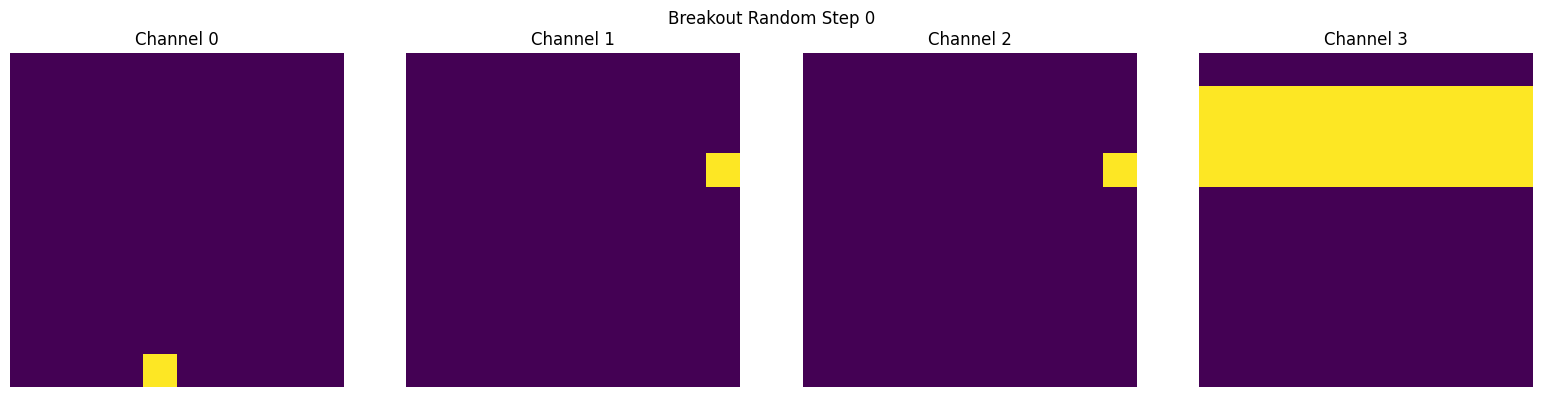

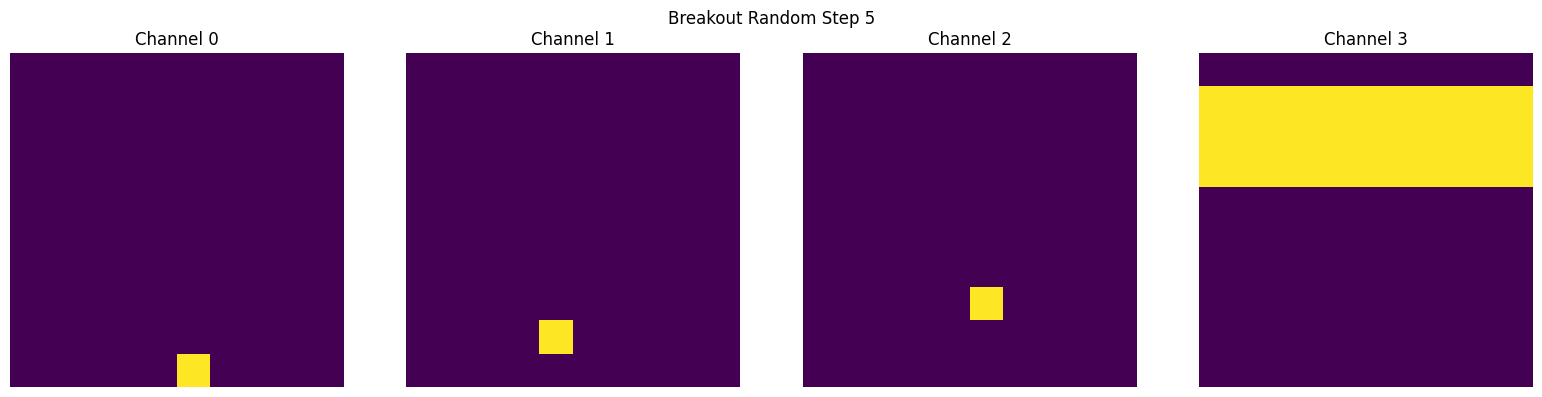

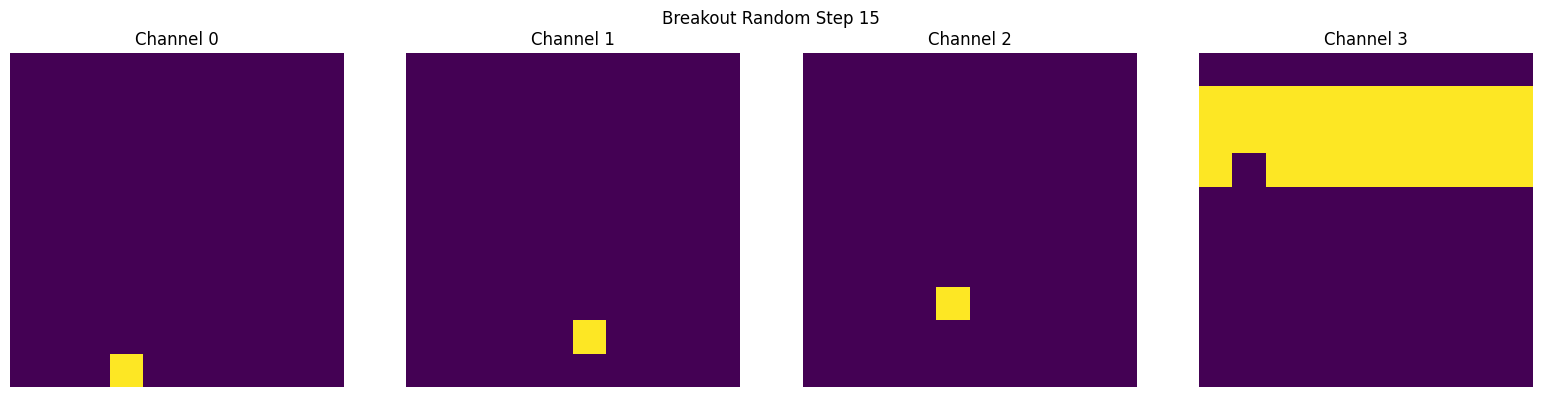

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from minatar import Environment

env = Environment("breakout")

print("===== Environment Specifications =====")
print("Number of actions:", env.num_actions())

state = env.state()
print("Observation shape:", state.shape)
print("Observation dtype:", state.dtype)
print("Observation values:", "min =", state.min(), ", max =", state.max())

env.reset()
terminated = False

show_steps = [0, 5, 15, 30]
max_step = max(show_steps)
t = 0

while not terminated and t <= max_step:
    if t in show_steps:
        state = env.state()  # (H, W, C)
        n_channels = state.shape[2]

        fig, axes = plt.subplots(1, n_channels, figsize=(4 * n_channels, 4))
        if n_channels == 1:
            axes = [axes]

        for i in range(n_channels):
            axes[i].imshow(state[:, :, i], interpolation="nearest")
            axes[i].set_title(f"Channel {i}")
            axes[i].axis("off")

        fig.suptitle(f"Breakout Random Step {t}")
        fig.tight_layout()
        plt.show()

    action = random.randrange(env.num_actions())
    reward, terminated = env.act(action)
    t += 1


### Ordered Actions

Number of actions: 6


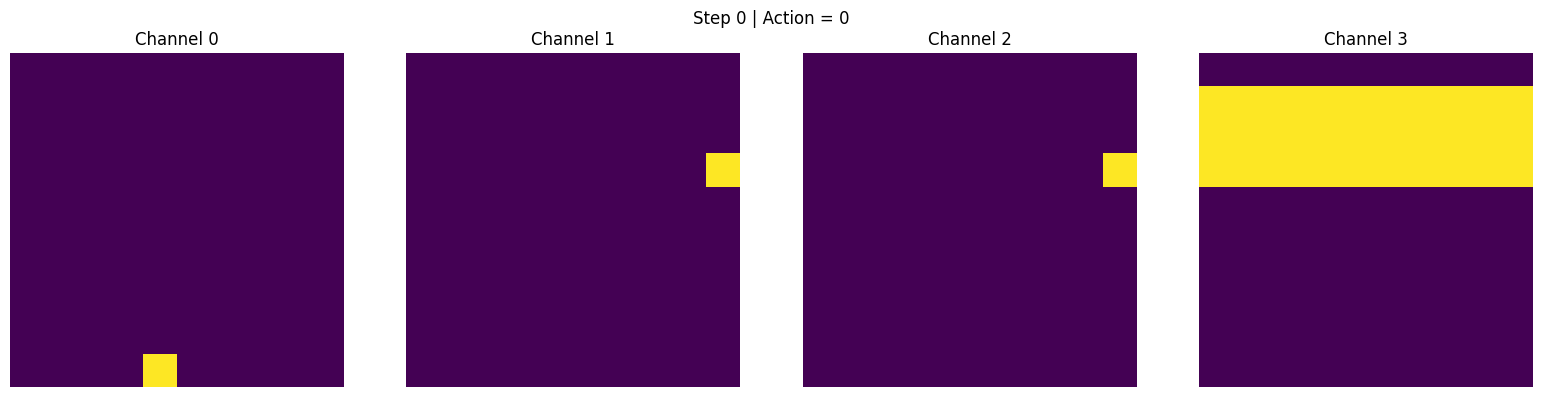

Step 0 | Took action 0 | Reward = 0


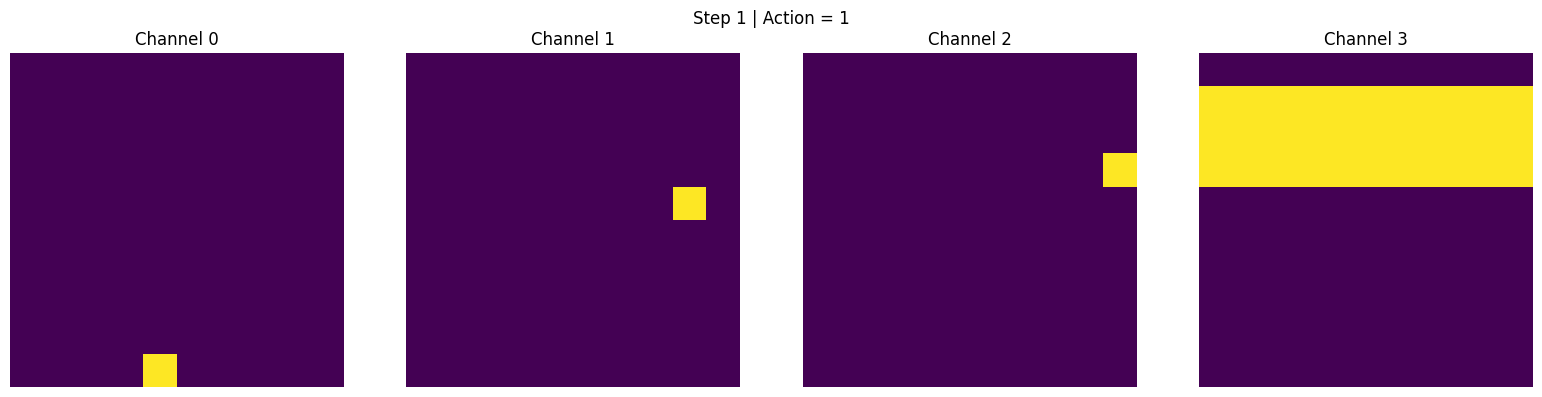

Step 1 | Took action 1 | Reward = 0


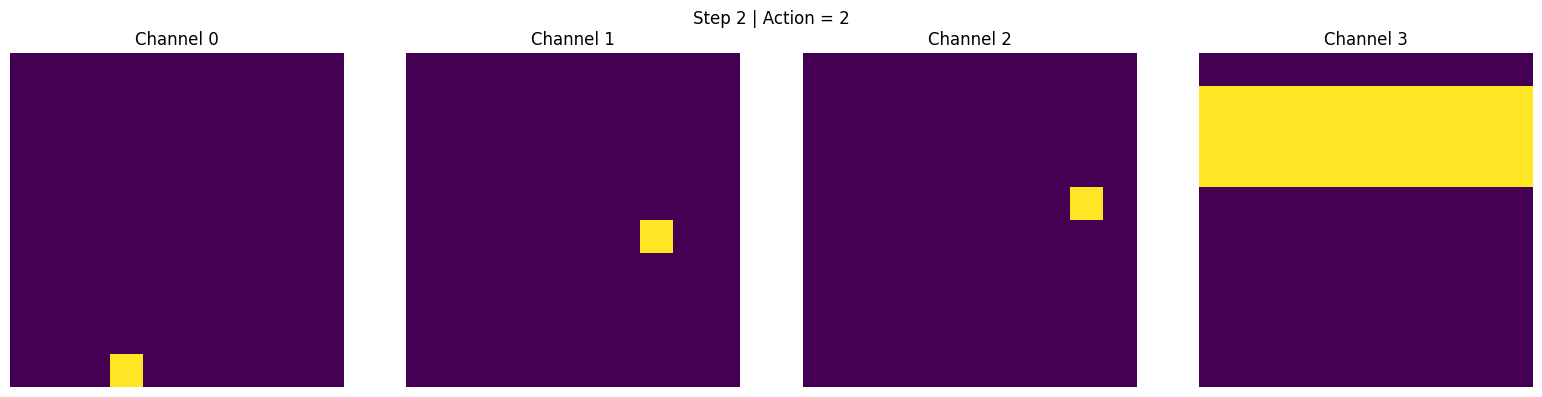

Step 2 | Took action 2 | Reward = 0


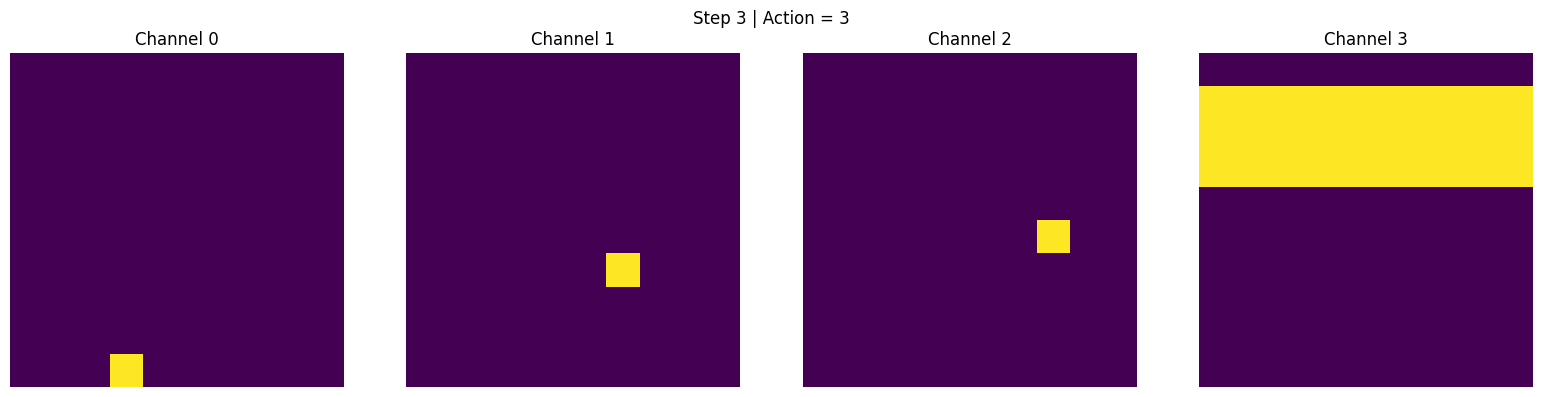

Step 3 | Took action 3 | Reward = 0


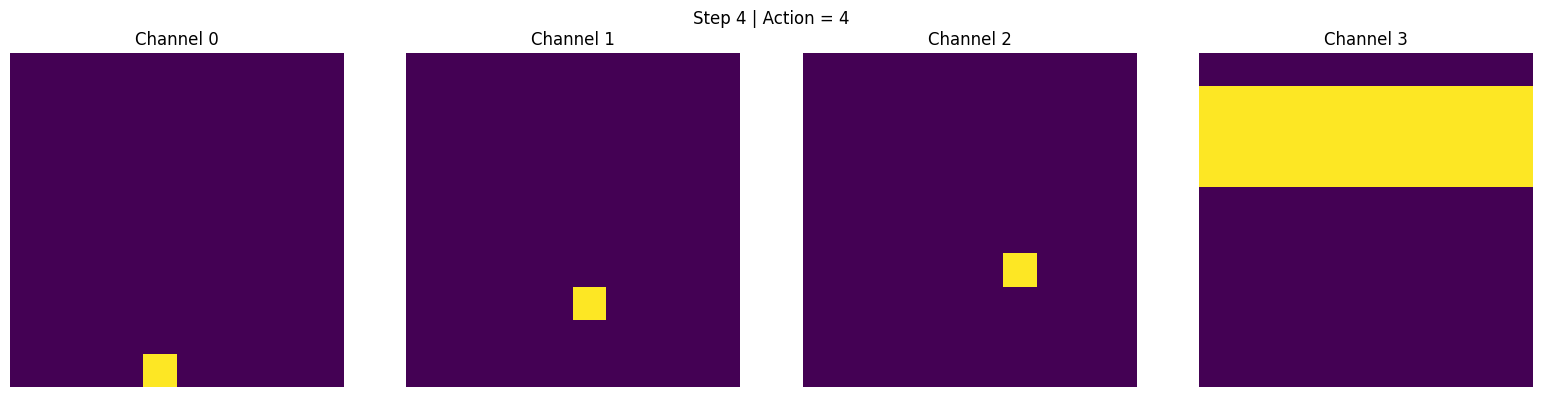

Step 4 | Took action 4 | Reward = 0


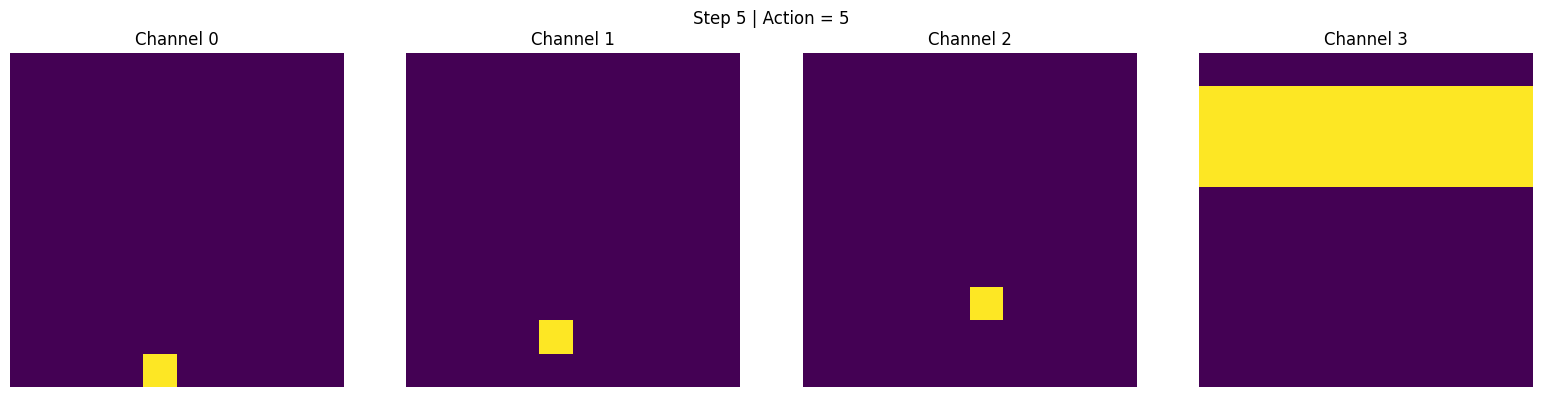

Step 5 | Took action 5 | Reward = 0


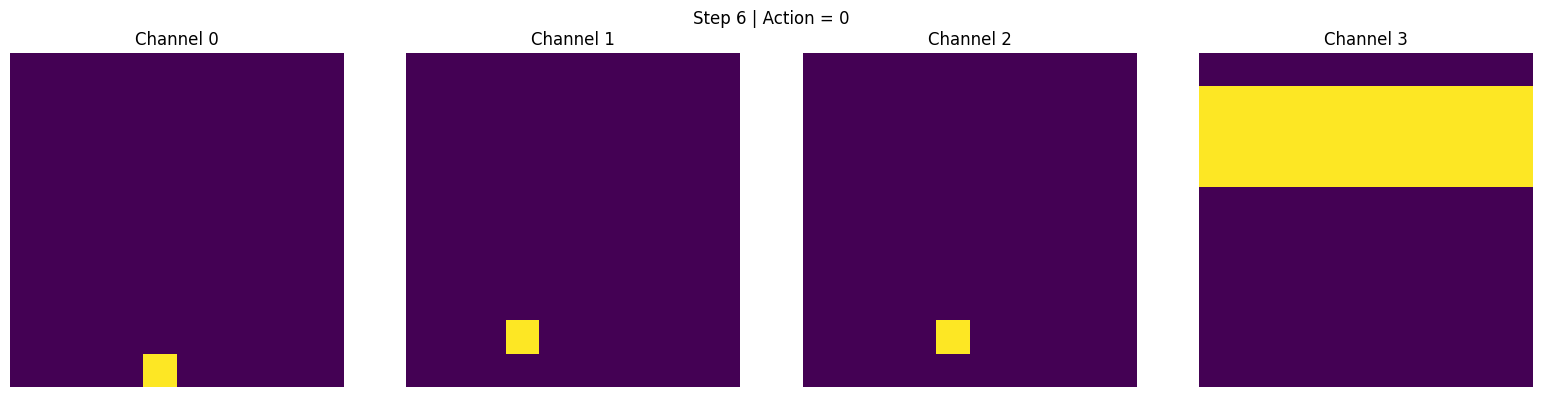

Step 6 | Took action 0 | Reward = 0


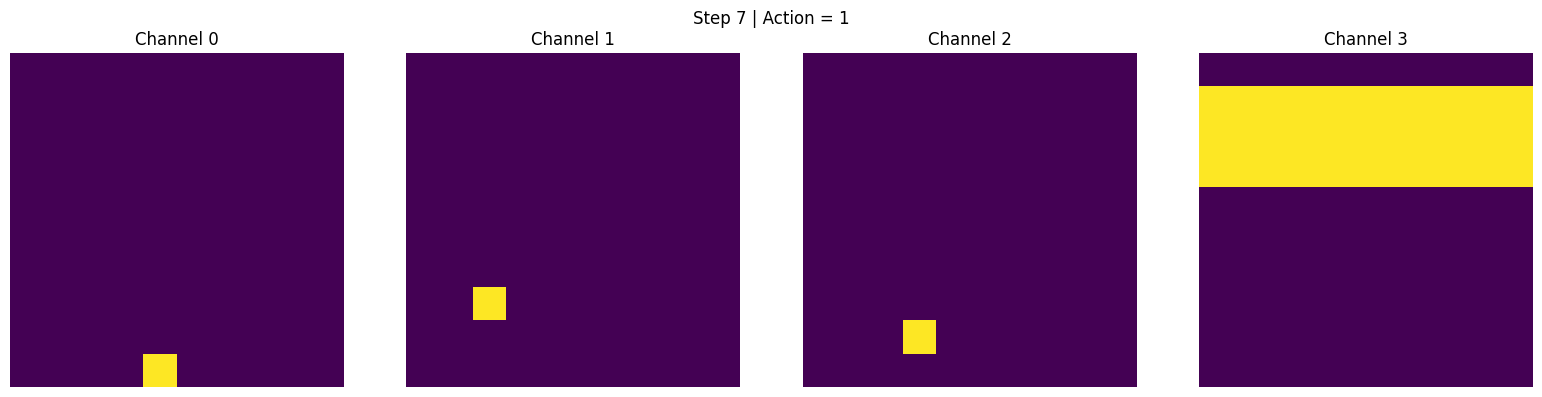

Step 7 | Took action 1 | Reward = 0


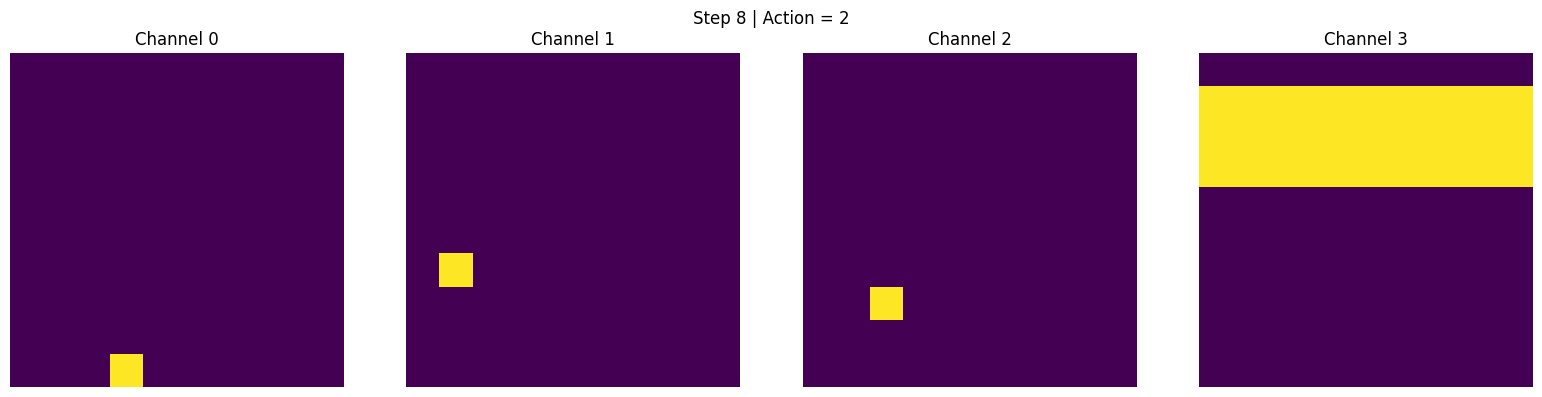

Step 8 | Took action 2 | Reward = 0


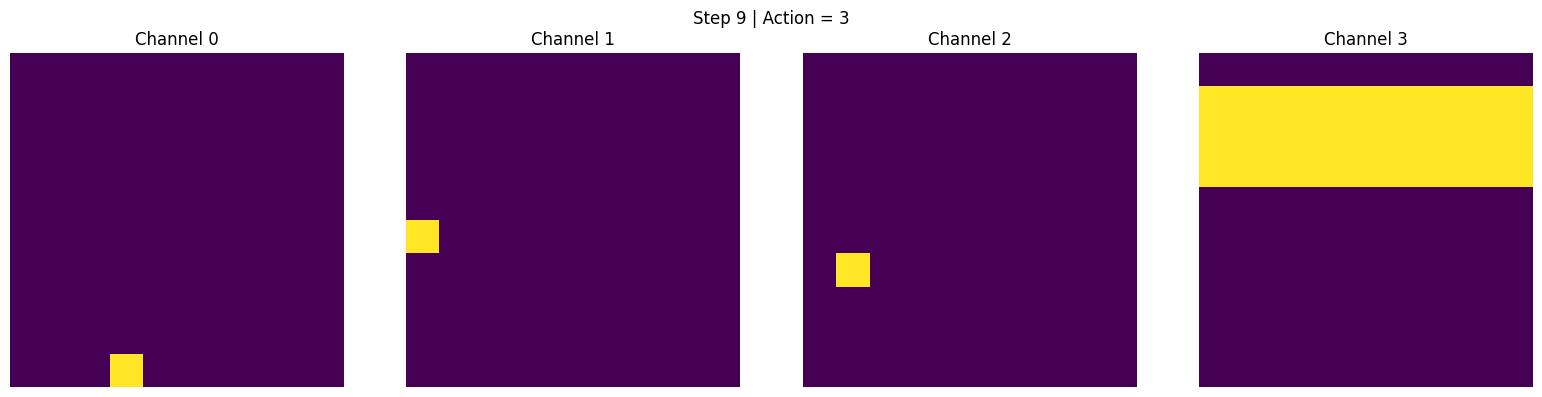

Step 9 | Took action 3 | Reward = 0


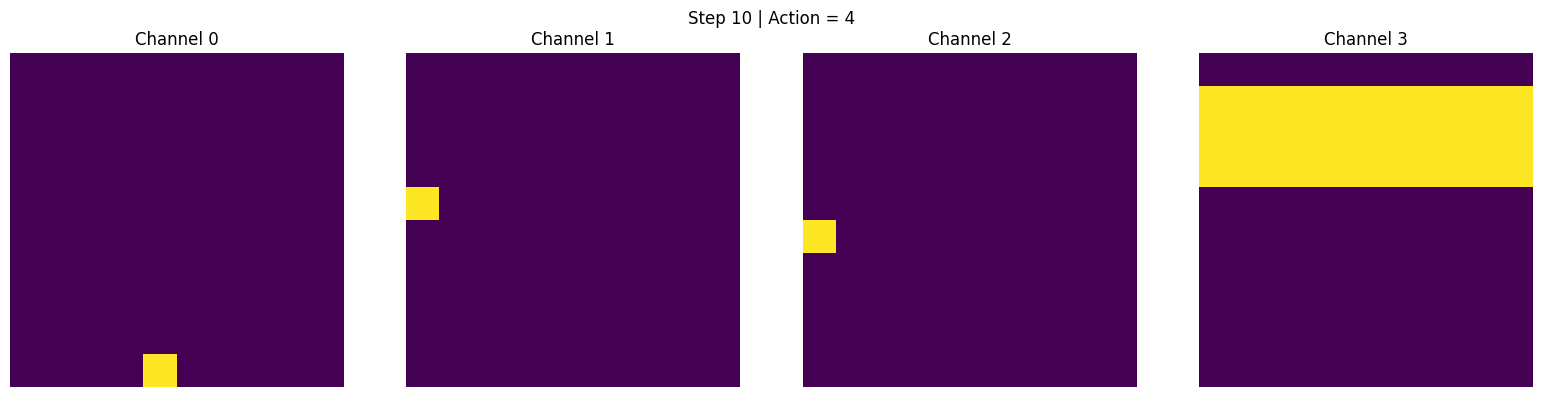

Step 10 | Took action 4 | Reward = 1


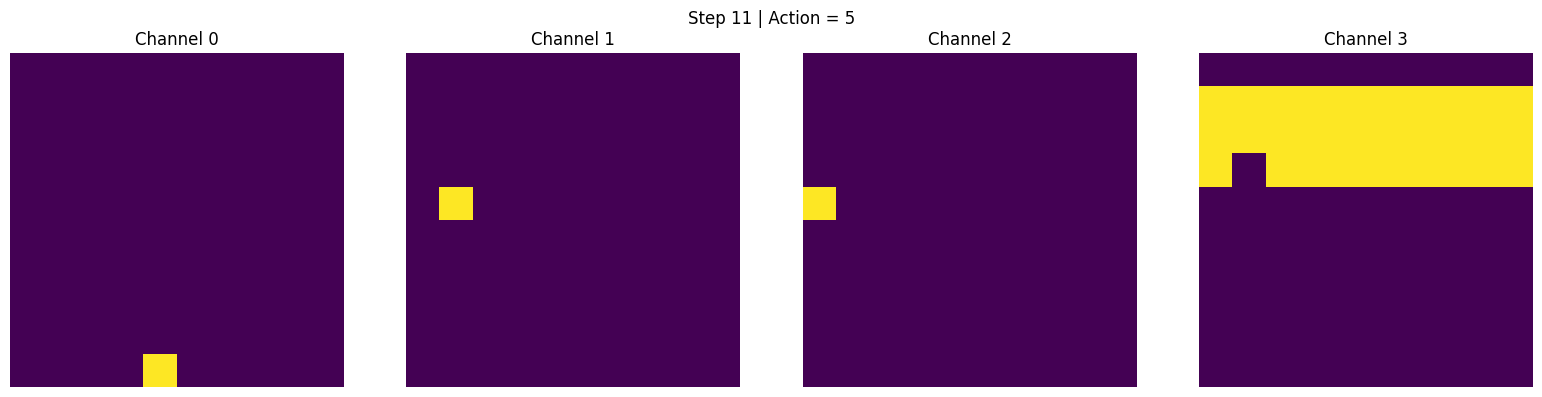

Step 11 | Took action 5 | Reward = 0


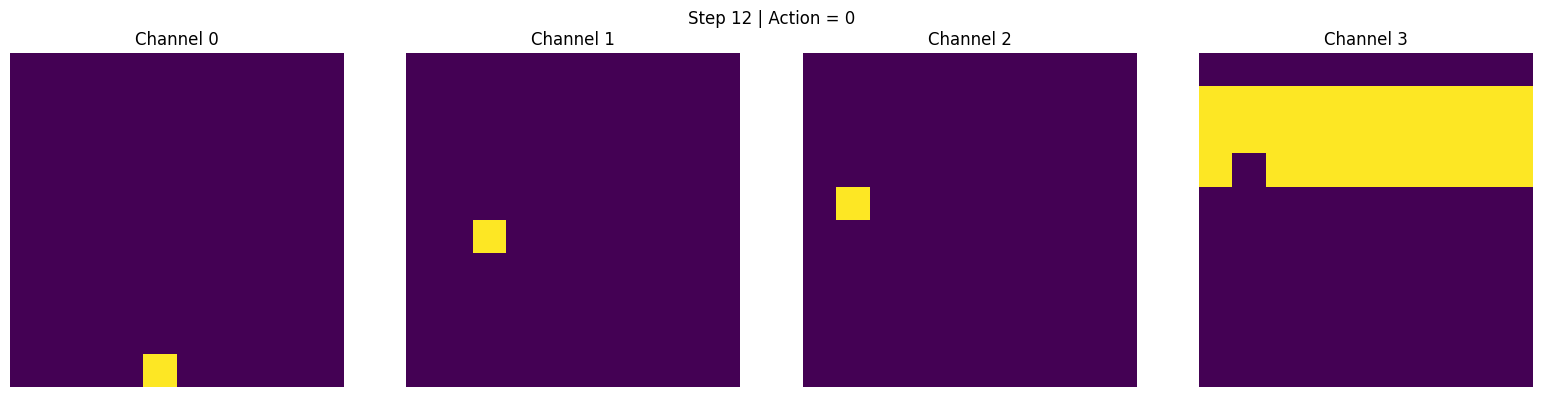

Step 12 | Took action 0 | Reward = 0


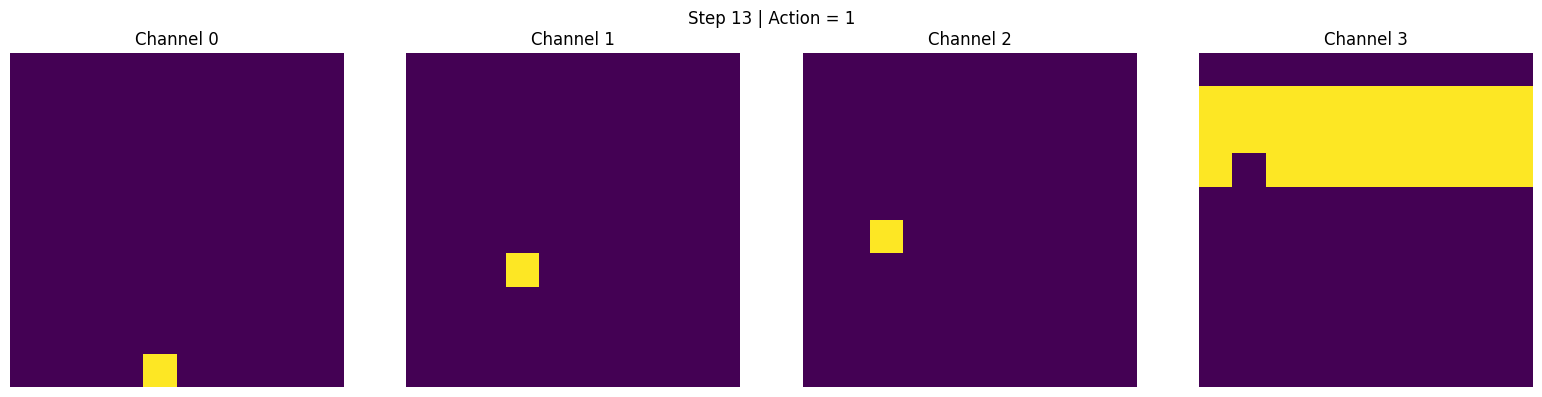

Step 13 | Took action 1 | Reward = 0


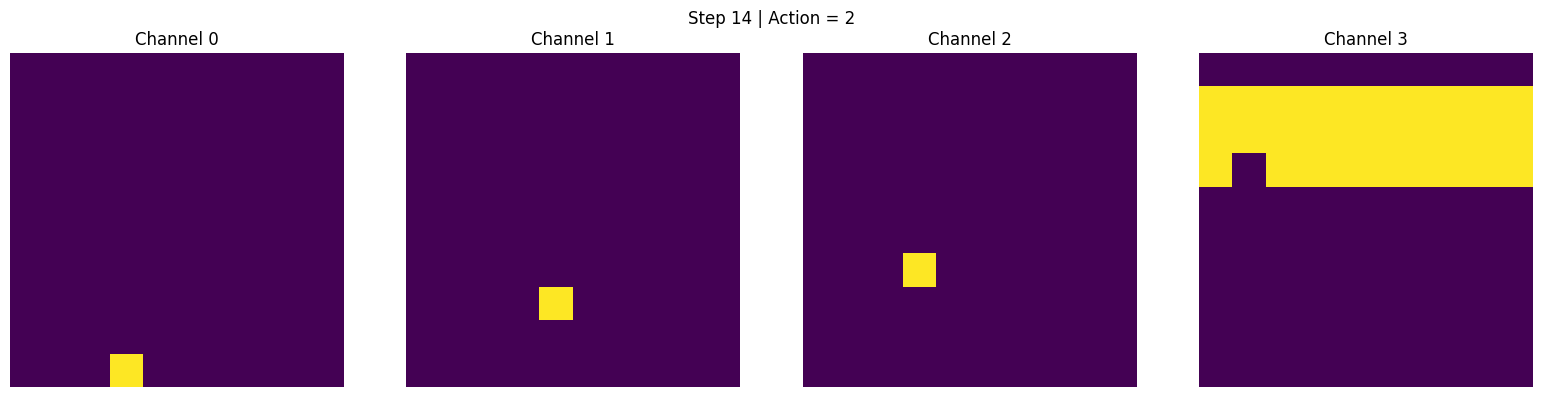

Step 14 | Took action 2 | Reward = 0


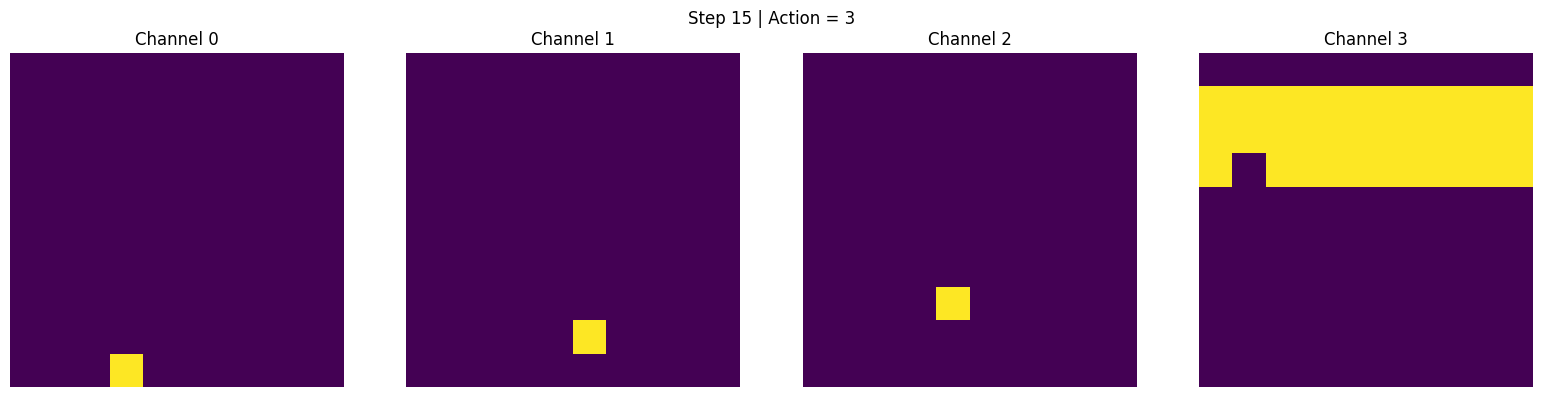

Step 15 | Took action 3 | Reward = 0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from minatar import Environment

env = Environment("breakout")
env.reset()

print("Number of actions:", env.num_actions())

terminated = False
t = 0
max_steps = 20

while not terminated and t < max_steps:

    # ---- Display current state ----
    state = env.state()  # (H, W, C)
    n_channels = state.shape[2]

    fig, axes = plt.subplots(1, n_channels, figsize=(4 * n_channels, 4))

    if n_channels == 1:
        axes = [axes]

    for i in range(n_channels):
        axes[i].imshow(state[:, :, i], interpolation="nearest")
        axes[i].set_title(f"Channel {i}")
        axes[i].axis("off")

    fig.suptitle(f"Step {t} | Action = {t % env.num_actions()}")
    fig.tight_layout()

    #clear_output(wait=True)   # makes it update like animation
    display(fig)
    plt.close(fig)

    # ---- Deterministic action sequence ----
    action = t % env.num_actions()
    reward, terminated = env.act(action)

    print(f"Step {t} | Took action {action} | Reward = {reward}")

    t += 1

## 3) (a) Description of Environment and Action Space

The environment provides observations of shape (10, 10, 4) with Boolean values {True, False}. Each observation consists of four 10×10 binary channels, which can be visualized as pixel grids (False = purple, True = yellow). Each channel represents a game component:

- Channel 0: Player paddle
- Channel 1: Ball
- Channel 2: Ball trail
- Channel 3: Bricks (targets)

This structured representation separates objects into different feature maps, simplifying perception compared to raw image inputs.

The action space consists of 6 discrete actions (integers 0–5). From visualization:

- 0: No move
- 1: Move paddle left
- 2: No move
- 3: Move paddle right
- 4: No move
- 5: No move

Only two actions directly affect the paddle position, the others introduce redundancy in the action space.

A reward of +1 is observed when the ball (Channel 1) collides with a brick (Channel 3), causing the brick to disappear.

## 3) (a1) (extra)

(a1) [Optional, 3 bonus points, you can’t have more than 100 points] Carefully inspect the dynamics of the Breakout-v1 environment and its visualizations. Based on empirical
investigation and/or reading the environment implementation, discuss whether there exists a small design issue that could make the observation process slightly non-Markovian when
each episode initiates. (Don’t worry, the experiment result won’t change significantly because of this!)

### Response:

There is a small design detail that may make the observation process slightly non-Markovian at episode initialization. Even if the ball’s position is observable, its velocity (direction of motion) is not explicitly encoded in the initial observation because both, the ball and its trail are in the same position. We have two identical initial observations could correspond to different internal velocity states, leading to different next-state transitions. This violates strict Markovity at the first time step. However, after one transition, the ball trail channel reveals motion direction, making the process Markovian.

## 3) (b) Code

(b) [24 points] Control with experience replay. Implement Deep Q-learning under:

- (i) Sequential updates (no replay buffer, use the most recent experience to update).
- (ii) Experience replay with uniform sampling.
- (iii) Experience replay with prioritized sampling.

Use a target network that is updated via hard parameter copying every 1000 environment steps. For the replay buffer, use capacity 50,000 and perform mini-batch TD updates with
batch size 64. For prioritized replay, specify the sampling rule based on TD error and include importance-sampling corrections. For each setting, test under different learning rates
𝛼 = {1𝑒−4, 5𝑒−4, 1𝑒−3}, and plot those three curves within one figure. Compare performance across the three settings and provide plausible explanations for the observed results. The
analysis should consider both environmental characteristics and algorithmic properties.

In [3]:
import os
import random
from dataclasses import dataclass
from typing import List, Dict, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import mlflow # For versioning

from minatar import Environment

# Import plotting function
from plotting import plot_compare_smoothed_rewards


# -------------------------
# Config
# -------------------------
@dataclass
class DQNConfig:
    env_name: str = "breakout"
    gamma: float = 0.99
    epsilon: float = 0.05
    hidden_dim: int = 128
    init_low: float = -0.001
    init_high: float = 0.001

    warmup_steps: int = 1000
    target_update_every: int = 1000  # env steps
    episodes: int = 3000
    max_steps_per_episode: int = 1000  # safety cap

    device: str = "cuda" if torch.cuda.is_available() else "cpu"


# -------------------------
# Utils
# -------------------------
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # deterministic-ish (may reduce speed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def obs_to_tensor(obs: np.ndarray, device: str) -> torch.Tensor:
    # MinAtar state is (10,10,C) bool; convert to float and flatten
    x = obs.astype(np.float32).reshape(-1)
    return torch.from_numpy(x).to(device)


def discounted_return(rewards: List[float], gamma: float) -> float:
    G = 0.0
    p = 1.0
    for r in rewards:
        G += p * r
        p *= gamma
    return G


# -------------------------
# Network
# -------------------------
class QNetwork(nn.Module):
    def __init__(self, input_dim: int, num_actions: int, hidden_dim: int,
                 init_low: float, init_high: float):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_actions),
        )
        self._init_weights(init_low, init_high)

    def _init_weights(self, low: float, high: float):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.uniform_(m.weight, a=low, b=high)
                nn.init.uniform_(m.bias, a=low, b=high)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


# -------------------------
# Action selection
# -------------------------
@torch.no_grad()
def epsilon_greedy_action(qnet: QNetwork, s: torch.Tensor, epsilon: float, num_actions: int) -> int:
    if random.random() < epsilon:
        return random.randrange(num_actions)
    q = qnet(s.unsqueeze(0))  # (1, A)
    return int(torch.argmax(q, dim=1).item())


# -------------------------
# One run (one seed, one lr)
# -------------------------
def run_dqn_sequential(seed: int, lr: float, cfg: DQNConfig) -> List[float]:
    set_seed(seed)

    env = Environment(cfg.env_name)
    num_actions = env.num_actions()

    # Determine input dim from an initial state
    env.reset()
    s0 = env.state()
    input_dim = int(np.prod(s0.shape))  # 10*10*C

    q = QNetwork(input_dim, num_actions, cfg.hidden_dim, cfg.init_low, cfg.init_high).to(cfg.device)
    q_tgt = QNetwork(input_dim, num_actions, cfg.hidden_dim, cfg.init_low, cfg.init_high).to(cfg.device)
    q_tgt.load_state_dict(q.state_dict())
    q_tgt.eval()

    optimizer = optim.Adam(q.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    env_steps = 0
    total_env_steps = 0

    # -------------------------
    # Warm-up: act randomly (or epsilon-greedy) and do NOT update
    # For sequential-updates, we still follow the "1000 warm-up steps" requirement.
    # -------------------------
    env.reset()
    terminated = False
    while env_steps < cfg.warmup_steps:
        if terminated:
            env.reset()
            terminated = False

        a = random.randrange(num_actions)  # pure random warmup
        r, terminated = env.act(a)
        env_steps += 1

    # -------------------------
    # Training
    # -------------------------
    episode_returns: List[float] = []

    for ep in range(cfg.episodes):
        env.reset()
        terminated = False
        ep_rewards: List[float] = []
        steps_in_ep = 0

        while not terminated and steps_in_ep < cfg.max_steps_per_episode:
            obs = env.state()
            s = obs_to_tensor(obs, cfg.device)

            # Choose action
            a = epsilon_greedy_action(q, s, cfg.epsilon, num_actions)

            # Step env
            r, terminated = env.act(a)
            ep_rewards.append(float(r))

            # Next state
            obs2 = env.state()
            s2 = obs_to_tensor(obs2, cfg.device)

            # -------------------------
            # Sequential TD update (batch size = 1 transition)
            # target = r + gamma * max_a' Q_tgt(s', a') if not done
            # -------------------------
            with torch.no_grad():
                q_next = q_tgt(s2.unsqueeze(0))           # (1, A)
                max_q_next = torch.max(q_next, dim=1)[0]  # (1,)
                y = torch.tensor([r], device=cfg.device, dtype=torch.float32)
                if not terminated:
                    y = y + cfg.gamma * max_q_next

            q_sa = q(s.unsqueeze(0))[0, a]  # scalar
            loss = loss_fn(q_sa, y.squeeze(0))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            env_steps += 1
            steps_in_ep += 1
            total_env_steps += 1

            # Target network hard update
            if env_steps % cfg.target_update_every == 0:
                q_tgt.load_state_dict(q.state_dict())

        G = discounted_return(ep_rewards, cfg.gamma)
        episode_returns.append(G)

        if (ep + 1) % 50 == 0:
            print(f"[lr={lr} | seed={seed}] "
                f"Episode {ep+1}/{cfg.episodes} | "
                f"Steps this ep: {steps_in_ep} | "
                f"Total env steps: {total_env_steps}")

        # MLflow
        if (ep + 1) % 50 == 0:
            mlflow.log_metric("discounted_return", float(G), step=ep)

    return episode_returns


# -------------------------
# Sweep: 3 learning rates, 5 seeds
# -------------------------
def experiment_sequential(cfg: DQNConfig,
                          lrs=(1e-4, 5e-4, 1e-3),
                          seeds=(0, 1, 2, 3, 4),
                          mlflow_experiment_name="COMP579_A3_DQN_Sequential"):

    mlflow.set_experiment(mlflow_experiment_name)

    # store as: lr -> list over seeds -> returns list over episodes
    results: Dict[float, List[List[float]]] = {}

    for lr in lrs:
        per_seed_returns: List[List[float]] = []

        # Parent run for this LR
        with mlflow.start_run(run_name=f"sequential_lr={lr}", nested=False):
            mlflow.log_params({
                "setting": "sequential_updates",
                "env": cfg.env_name,
                "lr": lr,
                "gamma": cfg.gamma,
                "epsilon": cfg.epsilon,
                "warmup_steps": cfg.warmup_steps,
                "target_update_every": cfg.target_update_every,
                "episodes": cfg.episodes,
                "hidden_dim": cfg.hidden_dim,
                "init_low": cfg.init_low,
                "init_high": cfg.init_high,
                "optimizer": "Adam",
            })

            for seed in seeds:
                with mlflow.start_run(run_name=f"seed={seed}", nested=True):
                    mlflow.log_param("seed", seed)
                    returns = run_dqn_sequential(seed=seed, lr=lr, cfg=cfg)
                    per_seed_returns.append(returns)

                    # log final performance summary too
                    mlflow.log_metric("final_100ep_mean_return", float(np.mean(returns[-100:])))

        results[lr] = per_seed_returns

    # Plot: three curves (each curve = mean±std across seeds) for the three lrs
    train_rewards_list = [results[lr] for lr in lrs]
    labels = [f"α={lr:g}" for lr in lrs]

    plot_compare_smoothed_rewards(
        train_rewards_list=train_rewards_list,
        labels=labels,
        window=10,
        xlabel="Episode",
        ylabel="Discounted return",
    )

    return results

d:\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[lr=0.0001 | seed=0] Episode 50/3000 | Steps this ep: 6 | Total env steps: 580
[lr=0.0001 | seed=0] Episode 100/3000 | Steps this ep: 26 | Total env steps: 1182
[lr=0.0001 | seed=0] Episode 150/3000 | Steps this ep: 6 | Total env steps: 1712
[lr=0.0001 | seed=0] Episode 200/3000 | Steps this ep: 6 | Total env steps: 2142
[lr=0.0001 | seed=0] Episode 250/3000 | Steps this ep: 6 | Total env steps: 2712
[lr=0.0001 | seed=0] Episode 300/3000 | Steps this ep: 6 | Total env steps: 3012
[lr=0.0001 | seed=0] Episode 350/3000 | Steps this ep: 16 | Total env steps: 3422
[lr=0.0001 | seed=0] Episode 400/3000 | Steps this ep: 6 | Total env steps: 3842
[lr=0.0001 | seed=0] Episode 450/3000 | Steps this ep: 6 | Total env steps: 4142
[lr=0.0001 | seed=0] Episode 500/3000 | Steps this ep: 6 | Total env steps: 4544
[lr=0.0001 | seed=0] Episode 550/3000 | Steps this ep: 6 | Total env steps: 4924
[lr=0.0001 | seed=0] Episode 600/3000 | Steps this ep: 6 | Total env steps: 5426
[lr=0.0001 | seed=0] Episode

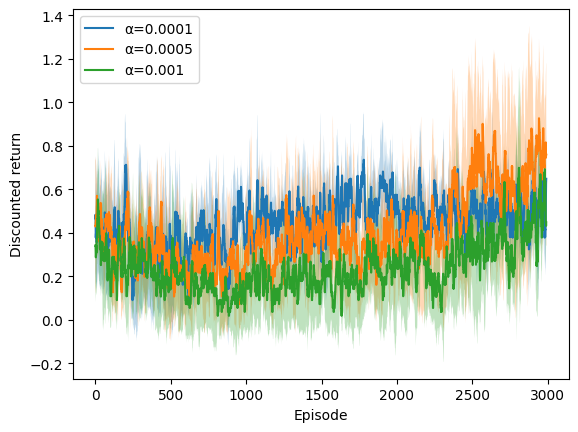

In [4]:
cfg = DQNConfig()
results = experiment_sequential(cfg)

### (b)(ii)

In [5]:
import os
import random
from dataclasses import dataclass
from typing import List, Dict, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import mlflow

from minatar import Environment
from plotting import plot_compare_smoothed_rewards


# -------------------------
# Config (same as before)
# -------------------------
@dataclass
class DQNConfig:
    env_name: str = "breakout"
    gamma: float = 0.99
    epsilon: float = 0.05
    hidden_dim: int = 128
    init_low: float = -0.001
    init_high: float = 0.001

    warmup_steps: int = 1000
    target_update_every: int = 1000
    episodes: int = 3000
    max_steps_per_episode: int = 1000

    device: str = "cuda" if torch.cuda.is_available() else "cpu"


# -------------------------
# Utils (same as before)
# -------------------------
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def obs_to_tensor(obs: np.ndarray, device: str) -> torch.Tensor:
    x = obs.astype(np.float32).reshape(-1)
    return torch.from_numpy(x).to(device)


def discounted_return(rewards: List[float], gamma: float) -> float:
    G = 0.0
    p = 1.0
    for r in rewards:
        G += p * r
        p *= gamma
    return G


# -------------------------
# Network (same as before)
# -------------------------
class QNetwork(nn.Module):
    def __init__(self, input_dim: int, num_actions: int, hidden_dim: int,
                 init_low: float, init_high: float):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_actions),
        )
        self._init_weights(init_low, init_high)

    def _init_weights(self, low: float, high: float):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.uniform_(m.weight, a=low, b=high)
                nn.init.uniform_(m.bias, a=low, b=high)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


@torch.no_grad()
def epsilon_greedy_action(qnet: QNetwork, s: torch.Tensor, epsilon: float, num_actions: int) -> int:
    if random.random() < epsilon:
        return random.randrange(num_actions)
    q = qnet(s.unsqueeze(0))
    return int(torch.argmax(q, dim=1).item())


# -------------------------
# Replay Buffer (uniform sampling)
# -------------------------
class ReplayBuffer:
    def __init__(self, capacity: int, obs_dim: int):
        self.capacity = capacity
        self.obs_dim = obs_dim
        self.ptr = 0
        self.size = 0

        self.s = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.a = np.zeros((capacity,), dtype=np.int64)
        self.r = np.zeros((capacity,), dtype=np.float32)
        self.s2 = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.done = np.zeros((capacity,), dtype=np.float32)  # 1.0 if done else 0.0

    def add(self, s, a, r, s2, done: bool):
        self.s[self.ptr] = s
        self.a[self.ptr] = a
        self.r[self.ptr] = r
        self.s2[self.ptr] = s2
        self.done[self.ptr] = 1.0 if done else 0.0

        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size: int):
        idx = np.random.randint(0, self.size, size=batch_size)
        return self.s[idx], self.a[idx], self.r[idx], self.s2[idx], self.done[idx]

    def __len__(self):
        return self.size


# -------------------------
# (b)(ii) One run: uniform replay
# -------------------------
def run_dqn_replay_uniform(seed: int, lr: float, cfg: DQNConfig,
                           buffer_capacity: int = 50_000,
                           batch_size: int = 64) -> List[float]:
    set_seed(seed)

    env = Environment(cfg.env_name)
    num_actions = env.num_actions()

    env.reset()
    s0 = env.state()
    obs_dim = int(np.prod(s0.shape))

    q = QNetwork(obs_dim, num_actions, cfg.hidden_dim, cfg.init_low, cfg.init_high).to(cfg.device)
    q_tgt = QNetwork(obs_dim, num_actions, cfg.hidden_dim, cfg.init_low, cfg.init_high).to(cfg.device)
    q_tgt.load_state_dict(q.state_dict())
    q_tgt.eval()

    optimizer = optim.Adam(q.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    # IMPORTANT: buffer must be cleared for each seed -> new buffer per run
    rb = ReplayBuffer(capacity=buffer_capacity, obs_dim=obs_dim)

    env_steps = 0
    total_env_steps = 0

    # -------- Warm-up: collect experience only (no updates) --------
    env.reset()
    terminated = False
    while env_steps < cfg.warmup_steps:
        if terminated:
            env.reset()
            terminated = False

        obs = env.state().astype(np.float32).reshape(-1)
        a = random.randrange(num_actions)
        r, terminated = env.act(a)
        obs2 = env.state().astype(np.float32).reshape(-1)

        rb.add(obs, a, float(r), obs2, terminated)
        env_steps += 1

    # -------- Training --------
    episode_returns: List[float] = []

    for ep in range(cfg.episodes):
        env.reset()
        terminated = False
        ep_rewards: List[float] = []
        steps_in_ep = 0

        while not terminated and steps_in_ep < cfg.max_steps_per_episode:
            obs = env.state().astype(np.float32).reshape(-1)
            s = torch.from_numpy(obs).to(cfg.device)

            a = epsilon_greedy_action(q, s, cfg.epsilon, num_actions)

            r, terminated = env.act(a)
            ep_rewards.append(float(r))

            obs2 = env.state().astype(np.float32).reshape(-1)

            # store transition
            rb.add(obs, a, float(r), obs2, terminated)

            # ----- One gradient step per env step -----
            # (buffer should already be >= warmup, but still guard)
            if len(rb) >= batch_size:
                bs, ba, br, bs2, bdone = rb.sample(batch_size)

                bs_t = torch.from_numpy(bs).to(cfg.device)
                ba_t = torch.from_numpy(ba).to(cfg.device)
                br_t = torch.from_numpy(br).to(cfg.device)
                bs2_t = torch.from_numpy(bs2).to(cfg.device)
                bdone_t = torch.from_numpy(bdone).to(cfg.device)

                # Q(s,a)
                q_values = q(bs_t)  # (B, A)
                q_sa = q_values.gather(1, ba_t.view(-1, 1)).squeeze(1)  # (B,)

                with torch.no_grad():
                    q_next = q_tgt(bs2_t)                  # (B, A)
                    max_q_next = torch.max(q_next, dim=1)[0]  # (B,)
                    y = br_t + (1.0 - bdone_t) * cfg.gamma * max_q_next

                loss = loss_fn(q_sa, y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            env_steps += 1
            steps_in_ep += 1
            total_env_steps += 1

            # Target network hard update
            if env_steps % cfg.target_update_every == 0:
                q_tgt.load_state_dict(q.state_dict())

        G = discounted_return(ep_rewards, cfg.gamma)
        episode_returns.append(G)

        if (ep + 1) % 50 == 0:
            print(f"[lr={lr} | seed={seed}] "
                f"Episode {ep+1}/{cfg.episodes} | "
                f"Steps this ep: {steps_in_ep} | "
                f"Total env steps: {total_env_steps}")
    
        # MLflow
        if (ep + 1) % 50 == 0:
            mlflow.log_metric("discounted_return", float(G), step=ep)

    return episode_returns


# -------------------------
# Experiment: 3 learning rates x 5 seeds
# -------------------------
def experiment_replay_uniform(cfg: DQNConfig,
                              lrs=(1e-4, 5e-4, 1e-3),
                              seeds=(0, 1, 2, 3, 4),
                              mlflow_experiment_name="COMP579_A3_DQN_Replay_Uniform"):

    mlflow.set_experiment(mlflow_experiment_name)

    results: Dict[float, List[List[float]]] = {}

    for lr in lrs:
        per_seed_returns: List[List[float]] = []

        with mlflow.start_run(run_name=f"uniform_replay_lr={lr}", nested=False):
            mlflow.log_params({
                "setting": "replay_uniform",
                "env": cfg.env_name,
                "lr": lr,
                "gamma": cfg.gamma,
                "epsilon": cfg.epsilon,
                "warmup_steps": cfg.warmup_steps,
                "target_update_every": cfg.target_update_every,
                "episodes": cfg.episodes,
                "hidden_dim": cfg.hidden_dim,
                "init_low": cfg.init_low,
                "init_high": cfg.init_high,
                "optimizer": "Adam",
                "replay_capacity": 50_000,
                "batch_size": 64,
            })

            for seed in seeds:
                with mlflow.start_run(run_name=f"seed={seed}", nested=True):
                    mlflow.log_param("seed", seed)
                    returns = run_dqn_replay_uniform(seed=seed, lr=lr, cfg=cfg,
                                                     buffer_capacity=50_000, batch_size=64)
                    per_seed_returns.append(returns)
                    mlflow.log_metric("final_100ep_mean_return", float(np.mean(returns[-100:])))

        results[lr] = per_seed_returns

    train_rewards_list = [results[lr] for lr in lrs]
    labels = [f"α={lr:g}" for lr in lrs]

    plot_compare_smoothed_rewards(
        train_rewards_list=train_rewards_list,
        labels=labels,
        window=10,
        xlabel="Episode",
        ylabel="Discounted return",
    )

    return results

2026/02/21 16:06:05 INFO mlflow.tracking.fluent: Experiment with name 'COMP579_A3_DQN_Replay_Uniform' does not exist. Creating a new experiment.


[lr=0.0001 | seed=0] Episode 50/3000 | Steps this ep: 6 | Total env steps: 550
[lr=0.0001 | seed=0] Episode 100/3000 | Steps this ep: 6 | Total env steps: 1000
[lr=0.0001 | seed=0] Episode 150/3000 | Steps this ep: 16 | Total env steps: 1540
[lr=0.0001 | seed=0] Episode 200/3000 | Steps this ep: 6 | Total env steps: 1900
[lr=0.0001 | seed=0] Episode 250/3000 | Steps this ep: 6 | Total env steps: 2392
[lr=0.0001 | seed=0] Episode 300/3000 | Steps this ep: 16 | Total env steps: 2832
[lr=0.0001 | seed=0] Episode 350/3000 | Steps this ep: 16 | Total env steps: 3352
[lr=0.0001 | seed=0] Episode 400/3000 | Steps this ep: 6 | Total env steps: 3934
[lr=0.0001 | seed=0] Episode 450/3000 | Steps this ep: 6 | Total env steps: 4504
[lr=0.0001 | seed=0] Episode 500/3000 | Steps this ep: 6 | Total env steps: 5084
[lr=0.0001 | seed=0] Episode 550/3000 | Steps this ep: 6 | Total env steps: 5584
[lr=0.0001 | seed=0] Episode 600/3000 | Steps this ep: 6 | Total env steps: 6144
[lr=0.0001 | seed=0] Episod

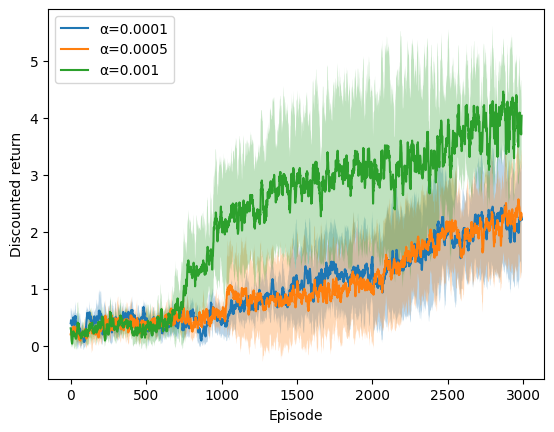

In [6]:
cfg = DQNConfig()
results = experiment_replay_uniform(cfg)

### (b)(iii)

In [ ]:
import random
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import mlflow

from minatar import Environment
from plotting import plot_compare_smoothed_rewards


# -------------------------
# Config (same as before)
# -------------------------
@dataclass
class DQNConfig:
    env_name: str = "breakout"
    gamma: float = 0.99
    epsilon: float = 0.05

    hidden_dim: int = 128
    init_low: float = -0.001
    init_high: float = 0.001

    warmup_steps: int = 1000
    target_update_every: int = 1000  # env steps

    episodes: int = 3000
    max_steps_per_episode: int = 1000  # safety cap

    device: str = "cuda" if torch.cuda.is_available() else "cpu"


# -------------------------
# Utils (same as before)
# -------------------------
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def obs_to_np_flat(obs: np.ndarray) -> np.ndarray:
    # MinAtar obs is bool (10,10,C) -> float32 flat vector
    return obs.astype(np.float32).reshape(-1)


def obs_to_tensor(obs_flat: np.ndarray, device: str) -> torch.Tensor:
    return torch.from_numpy(obs_flat).to(device)


def discounted_return(rewards: List[float], gamma: float) -> float:
    G = 0.0
    p = 1.0
    for r in rewards:
        G += p * r
        p *= gamma
    return G


# -------------------------
# Network (same as before)
# -------------------------
class QNetwork(nn.Module):
    def __init__(self, input_dim: int, num_actions: int, hidden_dim: int,
                 init_low: float, init_high: float):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_actions),
        )
        self._init_weights(init_low, init_high)

    def _init_weights(self, low: float, high: float):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.uniform_(m.weight, a=low, b=high)
                nn.init.uniform_(m.bias, a=low, b=high)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


@torch.no_grad()
def epsilon_greedy_action(qnet: QNetwork, s: torch.Tensor, epsilon: float, num_actions: int) -> int:
    if random.random() < epsilon:
        return random.randrange(num_actions)
    q = qnet(s.unsqueeze(0))
    return int(torch.argmax(q, dim=1).item())


# -------------------------
# Replay Buffer (Uniform + Prioritized via same sample() method)
# -------------------------
class ReplayBuffer:
    def __init__(self, capacity: int, obs_dim: int,
                 prioritized: bool = False,
                 prio_alpha: float = 0.6,
                 prio_eps: float = 1e-6):
        self.capacity = capacity
        self.obs_dim = obs_dim
        self.ptr = 0
        self.size = 0

        self.s = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.a = np.zeros((capacity,), dtype=np.int64)
        self.r = np.zeros((capacity,), dtype=np.float32)
        self.s2 = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.done = np.zeros((capacity,), dtype=np.float32)

        # Prioritized replay storage
        self.prioritized = prioritized
        self.prio_alpha = prio_alpha
        self.prio_eps = prio_eps
        self.prio = np.zeros((capacity,), dtype=np.float32)
        self.max_prio = 1.0

    def add(self, s, a, r, s2, done: bool):
        self.s[self.ptr] = s
        self.a[self.ptr] = a
        self.r[self.ptr] = r
        self.s2[self.ptr] = s2
        self.done[self.ptr] = 1.0 if done else 0.0

        # Set new transition priority to current maximum so it has a chance to be sampled
        if self.prioritized:
            self.prio[self.ptr] = self.max_prio

        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size: int, beta: float = 0.4):
        """
        If prioritized=False: uniform sample, returns (batch, None, None)
        If prioritized=True: proportional prioritized sample, returns (batch, idx, is_weights)
        """
        if self.size == 0:
            raise ValueError("Cannot sample from empty buffer")

        if not self.prioritized:
            idx = np.random.randint(0, self.size, size=batch_size)
            return (self.s[idx], self.a[idx], self.r[idx], self.s2[idx], self.done[idx]), None, None

        # proportional prioritization: P(i) ∝ (|δ_i| + eps)^alpha  (we store prio already as positive scalar)
        prios = self.prio[:self.size].copy()
        scaled = np.power(prios + self.prio_eps, self.prio_alpha)
        probs = scaled / np.sum(scaled)

        idx = np.random.choice(self.size, size=batch_size, replace=True, p=probs)

        # importance sampling weights: w_i = (N * P(i))^{-beta}, normalize by max in batch
        N = self.size
        w = np.power(N * probs[idx], -beta).astype(np.float32)
        w /= (w.max() + 1e-8)

        batch = (self.s[idx], self.a[idx], self.r[idx], self.s2[idx], self.done[idx])
        return batch, idx, w

    def update_priorities(self, idx: np.ndarray, td_errors: np.ndarray):
        """
        Update priorities based on TD-error magnitude.
        Priority rule: p_i = |δ_i| + eps
        """
        if not self.prioritized:
            return
        new_p = np.abs(td_errors).astype(np.float32) + self.prio_eps
        self.prio[idx] = new_p
        self.max_prio = max(self.max_prio, float(new_p.max()))

    def __len__(self):
        return self.size


# -------------------------
# (b)(iii) One run: prioritized replay
# -------------------------
def run_dqn_replay_prioritized(seed: int, lr: float, cfg: DQNConfig,
                               buffer_capacity: int = 50_000,
                               batch_size: int = 64,
                               prio_alpha: float = 0.6,
                               beta_start: float = 0.4,
                               beta_end: float = 1.0) -> List[float]:
    set_seed(seed)

    env = Environment(cfg.env_name)
    num_actions = env.num_actions()

    env.reset()
    obs_dim = int(np.prod(env.state().shape))

    q = QNetwork(obs_dim, num_actions, cfg.hidden_dim, cfg.init_low, cfg.init_high).to(cfg.device)
    q_tgt = QNetwork(obs_dim, num_actions, cfg.hidden_dim, cfg.init_low, cfg.init_high).to(cfg.device)
    q_tgt.load_state_dict(q.state_dict())
    q_tgt.eval()

    optimizer = optim.Adam(q.parameters(), lr=lr)

    # Buffer must be cleared per seed: create a fresh one here
    rb = ReplayBuffer(capacity=buffer_capacity, obs_dim=obs_dim,
                      prioritized=True, prio_alpha=prio_alpha)

    env_steps = 0
    total_env_steps = 0

    # -------- Warm-up: collect experience only (no updates) --------
    env.reset()
    terminated = False
    while env_steps < cfg.warmup_steps:
        if terminated:
            env.reset()
            terminated = False

        s = obs_to_np_flat(env.state())
        a = random.randrange(num_actions)  # random warmup
        r, terminated = env.act(a)
        s2 = obs_to_np_flat(env.state())
        rb.add(s, a, float(r), s2, terminated)
        env_steps += 1

    # -------- Training --------
    episode_returns: List[float] = []

    for ep in range(cfg.episodes):
        env.reset()
        terminated = False
        ep_rewards: List[float] = []
        steps_in_ep = 0

        # Anneal beta linearly over episodes (simple + standard)
        frac = ep / max(1, cfg.episodes - 1)
        beta = beta_start + frac * (beta_end - beta_start)

        while not terminated and steps_in_ep < cfg.max_steps_per_episode:
            s_np = obs_to_np_flat(env.state())
            s = obs_to_tensor(s_np, cfg.device)

            a = epsilon_greedy_action(q, s, cfg.epsilon, num_actions)
            r, terminated = env.act(a)
            ep_rewards.append(float(r))

            s2_np = obs_to_np_flat(env.state())

            rb.add(s_np, a, float(r), s2_np, terminated)

            # ----- One gradient step per env step -----
            if len(rb) >= batch_size:
                (bs, ba, br, bs2, bdone), idx, is_w = rb.sample(batch_size, beta=beta)

                bs_t = torch.from_numpy(bs).to(cfg.device)
                ba_t = torch.from_numpy(ba).to(cfg.device)
                br_t = torch.from_numpy(br).to(cfg.device)
                bs2_t = torch.from_numpy(bs2).to(cfg.device)
                bdone_t = torch.from_numpy(bdone).to(cfg.device)

                # Q(s,a)
                q_values = q(bs_t)  # (B, A)
                q_sa = q_values.gather(1, ba_t.view(-1, 1)).squeeze(1)  # (B,)

                with torch.no_grad():
                    q_next = q_tgt(bs2_t)  # (B, A)
                    max_q_next = torch.max(q_next, dim=1)[0]  # (B,)
                    y = br_t + (1.0 - bdone_t) * cfg.gamma * max_q_next  # (B,)

                td_err = (q_sa - y)  # (B,)

                # Importance-sampled loss: mean( w_i * (δ_i)^2 )
                w_t = torch.from_numpy(is_w).to(cfg.device)
                loss = torch.mean(w_t * (td_err ** 2))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Update priorities from TD-error (detach to numpy)
                rb.update_priorities(idx, td_errors=td_err.detach().cpu().numpy())

            env_steps += 1
            steps_in_ep += 1
            total_env_steps += 1

            # Target network hard update
            if env_steps % cfg.target_update_every == 0:
                q_tgt.load_state_dict(q.state_dict())

        G = discounted_return(ep_rewards, cfg.gamma)
        episode_returns.append(G)

        if (ep + 1) % 50 == 0:
            print(f"[lr={lr} | seed={seed}] "
                f"Episode {ep+1}/{cfg.episodes} | "
                f"Steps this ep: {steps_in_ep} | "
                f"Total env steps: {total_env_steps}")

        # MLflow
        if (ep + 1) % 50 == 0:
            mlflow.log_metric("discounted_return", float(G), step=ep)

    return episode_returns


# -------------------------
# Experiment: 3 learning rates x 5 seeds (Prioritized Replay)
# -------------------------
def experiment_replay_prioritized(cfg: DQNConfig,
                                  lrs=(1e-4, 5e-4, 1e-3),
                                  seeds=(0, 1, 2, 3, 4),
                                  mlflow_experiment_name="COMP579_A3_DQN_Replay_Prioritized"):

    mlflow.set_experiment(mlflow_experiment_name)

    results: Dict[float, List[List[float]]] = {}

    for lr in lrs:
        per_seed_returns: List[List[float]] = []

        with mlflow.start_run(run_name=f"prioritized_replay_lr={lr}", nested=False):
            mlflow.log_params({
                "setting": "replay_prioritized",
                "env": cfg.env_name,
                "lr": lr,
                "gamma": cfg.gamma,
                "epsilon": cfg.epsilon,
                "warmup_steps": cfg.warmup_steps,
                "target_update_every": cfg.target_update_every,
                "episodes": cfg.episodes,
                "hidden_dim": cfg.hidden_dim,
                "init_low": cfg.init_low,
                "init_high": cfg.init_high,
                "optimizer": "Adam",
                "replay_capacity": 50_000,
                "batch_size": 64,
                "prio_alpha": 0.6,
                "beta_start": 0.4,
                "beta_end": 1.0,
                "prio_eps": 1e-6,
            })

            for seed in seeds:
                with mlflow.start_run(run_name=f"seed={seed}", nested=True):
                    mlflow.log_param("seed", seed)

                    returns = run_dqn_replay_prioritized(
                        seed=seed,
                        lr=lr,
                        cfg=cfg,
                        buffer_capacity=50_000,
                        batch_size=64,
                        prio_alpha=0.6,
                        beta_start=0.4,
                        beta_end=1.0,
                    )
                    per_seed_returns.append(returns)

                    mlflow.log_metric("final_100ep_mean_return", float(np.mean(returns[-100:])))

        results[lr] = per_seed_returns

    # Plot 3 curves (mean±std across seeds) for the 3 learning rates
    train_rewards_list = [results[lr] for lr in lrs]
    labels = [f"α={lr:g}" for lr in lrs]

    plot_compare_smoothed_rewards(
        train_rewards_list=train_rewards_list,
        labels=labels,
        window=10,
        xlabel="Episode",
        ylabel="Discounted return",
    )

    return results

2026/02/21 16:58:31 INFO mlflow.tracking.fluent: Experiment with name 'COMP579_A3_DQN_Replay_Prioritized' does not exist. Creating a new experiment.


[lr=0.0001 | seed=0] Episode 50/3000 | Steps this ep: 16 | Total env steps: 512
[lr=0.0001 | seed=0] Episode 100/3000 | Steps this ep: 6 | Total env steps: 1002
[lr=0.0001 | seed=0] Episode 150/3000 | Steps this ep: 6 | Total env steps: 1434
[lr=0.0001 | seed=0] Episode 200/3000 | Steps this ep: 6 | Total env steps: 1734
[lr=0.0001 | seed=0] Episode 250/3000 | Steps this ep: 28 | Total env steps: 2098
[lr=0.0001 | seed=0] Episode 300/3000 | Steps this ep: 16 | Total env steps: 2690
[lr=0.0001 | seed=0] Episode 350/3000 | Steps this ep: 16 | Total env steps: 3280
[lr=0.0001 | seed=0] Episode 400/3000 | Steps this ep: 6 | Total env steps: 3840
[lr=0.0001 | seed=0] Episode 450/3000 | Steps this ep: 6 | Total env steps: 4360
[lr=0.0001 | seed=0] Episode 500/3000 | Steps this ep: 6 | Total env steps: 4904
[lr=0.0001 | seed=0] Episode 550/3000 | Steps this ep: 38 | Total env steps: 5468
[lr=0.0001 | seed=0] Episode 600/3000 | Steps this ep: 16 | Total env steps: 6078
[lr=0.0001 | seed=0] Epi

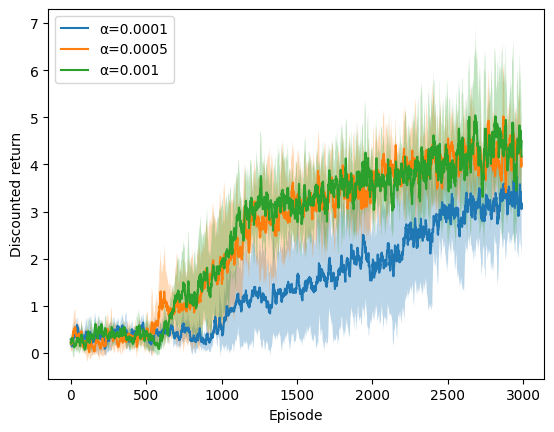

In [8]:
cfg = DQNConfig()
results = experiment_replay_prioritized(cfg)

## 3) (b) Results Analysis & Conclusions

#### b (i) Sequential DQN (No Replay Buffer)

For the DQN implementation with sequential updates, based on the Discounted Return vs Episode curves we observe that variance is quite high and learning is intermittent. The curves are noisy and improvements are unstable across episodes.

For α = 0.001, we see the lowest discounted return during most of training, although after approximately episode 2500 a plausible upward trend appears. For α = 0.0001, we observe the highest average discounted reward until around episode 2500. After that point, α = 0.0005 begins to exhibit clearer learning behaviour and eventually surpasses the others. From episodes 2500 to 3000, α = 0.0005 achieves the highest discounted return among the three learning rates.

In all three cases, learning is slow and inconsistent. Even after 3000 episodes, the discounted returns averaged across 5 seeds do not surpass 1. This suggests that the instability is primarily due to the update mechanism, not the network architecture, since the architecture is identical across experiments. As will be shown in the following settings, using the same network and hyperparameters but modifying the update strategy leads to significantly higher performance.

The poor performance of sequential updates can be explained by:

- Strong correlation between consecutive samples.
- Non-stationary target values due to online updates.
- High variance in TD targets.

These factors are especially problematic in a sparse-reward environment like this one, where reward is only received when a brick is destroyed.

#### b (ii) DQN with Experience Replay (Uniform Sampling)

For DQN with experience replay using uniform sampling, the results improve significantly and the plots become much easier to interpret.

For α = 0.001, we observe the best overall performance. The curve shows a clear learning trajectory, reaching a discounted return close to 4 by episode 3000. For α = 0.0001 and α = 0.0005, performance is similar, with both achieving slightly above 2 in discounted return by episode 3000. In all three cases, learning behaviour is clearly visible and much more stable compared to sequential updates.

The improvement can be attributed to:

- Breaking temporal correlations by sampling randomly from the buffer.
- Reusing past experiences multiple times.
- Stabilizing the target distribution.

In this setting, the larger learning rate (α = 0.001) performs best. Since the environment is relatively small (10×10 grid, discrete actions, simple dynamics), a larger learning rate can accelerate convergence without causing severe divergence. However, the variance of α = 0.001 appears higher than that of smaller learning rates, indicating increased update magnitude and sensitivity to noise.

#### b (iii) DQN with Prioritized Experience Replay

Finally, we consider DQN with prioritized experience replay.

This setting yields the best overall results. Clear learning behaviour is observed for all learning rates, and discounted returns are consistently higher than in the previous two methods.

The best learning rate is α = 0.001, reaching over 4.5 in discounted return by episode 3000. This is slightly better than α = 0.0005, which performs similarly but remains marginally lower. The worst-performing learning rate is α = 0.0001, which still achieves over 3 in discounted return by episode 3000, significantly better than sequential updates and uniform replay with the same learning rate.

The improvement from prioritized replay can be explained by:

- Sampling transitions with larger TD error more frequently.
- Focusing updates on informative or surprising transitions.
- Improving sample efficiency.

Unlike sequential updates, prioritized replay reduces variance and accelerates propagation of meaningful reward signals.

#### Conclusions

As expected from theory, experience replay with prioritized sampling outperforms the other two approaches. Experience replay stabilizes learning by decorrelating samples and approximating the i.i.d. assumption of supervised learning. Prioritized sampling further improves performance by emphasizing transitions with large TD errors, which accelerates value propagation.

It is important to clarify one point: prioritized replay does not solve an “off-policy distribution mismatch problem.” DQN is already off-policy. Instead, prioritized replay improves sample efficiency and learning speed by biasing the sampling distribution toward high-TD-error transitions while correcting for that bias using importance sampling.

The environment also plays an important role. Breakout has:

- A small discrete action space (6 actions, but effectively only 2 meaningful ones).
- Sparse rewards (reward only when bricks are destroyed).
- Simple state representation (binary 10×10×4 grid).

Because the state and action spaces are relatively small, higher learning rates can perform well without causing instability. However, sparse rewards make correlated updates particularly harmful, which explains why sequential DQN performs poorly compared to replay-based methods. Overall, the results demonstrate that:

- Sequential updates suffer from instability and poor sample efficiency.
- Uniform replay significantly improves stability and learning speed.
- Prioritized replay provides the best performance by focusing updates on informative transitions.

## 4) (a) Code

(a) [10 points] Implement the base REINFORCE algorithm, as well as REINFORCE with baseline using neural network function approximators. Use a learned baseline, i.e., a neural network that approximates the state value function 𝑉(𝑠). Use a Boltzmann policy with temperature 𝑇,
𝜋(𝑎𝑖 | 𝑠) = exp(𝑧(𝑠, 𝑎𝑖)/𝑇) Í
𝑗 exp(𝑧(𝑠, 𝑎 𝑗 )/𝑇) ,
where 𝑧(𝑠, 𝑎𝑖) is the output of a neural network (logit).
Initialize the temperature at 𝑇0 = 10.0 and decay it exponentially with decay factor 0.99.
Enforce a lower bound 𝑇 ≥ 0.5 to maintain sufficient exploration. Mathematically,
𝑇𝑛+1 = max(0.5, 0.99 𝑇𝑛),
where 𝑛 denotes the current episode number. For the value function network, use 𝛼𝑉 = 1𝑒−3 and 𝛼𝜋 = 1𝑒−4 for the policy network. Compare the two algorithm, and plot the two curves within one figure.

===== Environment Specifications =====
Action space: Discrete(2)
Observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)

===== Initial Observation =====
Observation shape: (4,)
Observation dtype: float32
Observation values: [ 0.01369617 -0.02302133 -0.04590265 -0.04834723]


d:\Python313\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


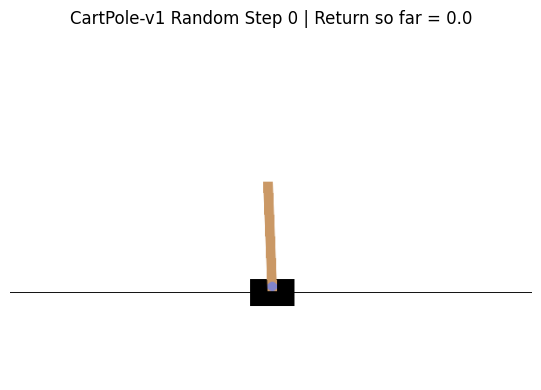


Step 0 observation: [ 0.01369617 -0.02302133 -0.04590265 -0.04834723]


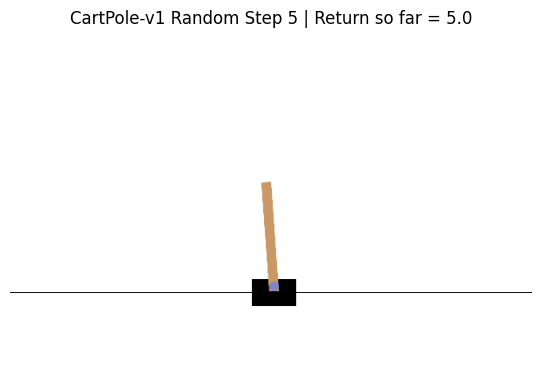


Step 5 observation: [ 0.02713983  0.17582907 -0.07719082 -0.42436373]


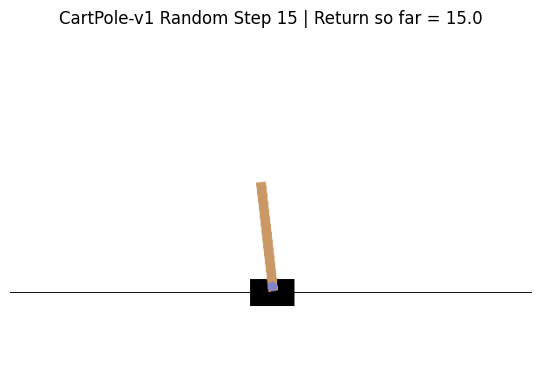


Step 15 observation: [ 0.01274027 -0.20071599 -0.11158853 -0.14087768]

Done.
Final step reached: 22
Episode return: 22.0
terminated: True | truncated: False


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

ENV_ID = "CartPole-v1"

# Create env with RGB rendering (so we can plot frames)
env = gym.make(ENV_ID, render_mode="rgb_array")

print("===== Environment Specifications =====")
print("Action space:", env.action_space)         
print("Observation space:", env.observation_space) 

# Reset (Gymnasium returns obs, info)
obs, info = env.reset(seed=0)

print("\n===== Initial Observation =====")
print("Observation shape:", obs.shape)          
print("Observation dtype:", obs.dtype)
print("Observation values:", obs)

# Choose  timesteps  to visualize
show_steps = [0, 5, 15, 30]
max_step = max(show_steps)

terminated = False
truncated = False
t = 0
episode_return = 0.0

while not (terminated or truncated) and t <= max_step:
    # Render and show at specific steps
    if t in show_steps:
        frame = env.render()

        plt.figure(figsize=(6, 4))
        plt.imshow(frame)
        plt.title(f"{ENV_ID} Random Step {t} | Return so far = {episode_return:.1f}")
        plt.axis("off")
        plt.tight_layout()
        plt.show()

        #print current state vector for reference
        print(f"\nStep {t} observation:", obs)

    # Random action
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    episode_return += reward
    t += 1

print("\nDone.")
print("Final step reached:", t)
print("Episode return:", episode_return)
print("terminated:", terminated, "| truncated:", truncated)

env.close()

[seed=0] Episode 100/1000 | Steps this ep: 27 | Temp this ep: 3.660323412732291 | 
[seed=0] Episode 200/1000 | Steps this ep: 45 | Temp this ep: 1.339796748579617 | 
[seed=0] Episode 300/1000 | Steps this ep: 14 | Temp this ep: 0.5 | 
[seed=0] Episode 400/1000 | Steps this ep: 68 | Temp this ep: 0.5 | 
[seed=0] Episode 500/1000 | Steps this ep: 51 | Temp this ep: 0.5 | 
[seed=0] Episode 600/1000 | Steps this ep: 52 | Temp this ep: 0.5 | 
[seed=0] Episode 700/1000 | Steps this ep: 130 | Temp this ep: 0.5 | 
[seed=0] Episode 800/1000 | Steps this ep: 153 | Temp this ep: 0.5 | 
[seed=0] Episode 900/1000 | Steps this ep: 285 | Temp this ep: 0.5 | 
[seed=0] Episode 1000/1000 | Steps this ep: 145 | Temp this ep: 0.5 | 
[seed=1] Episode 100/1000 | Steps this ep: 16 | Temp this ep: 3.660323412732291 | 
[seed=1] Episode 200/1000 | Steps this ep: 19 | Temp this ep: 1.339796748579617 | 
[seed=1] Episode 300/1000 | Steps this ep: 40 | Temp this ep: 0.5 | 
[seed=1] Episode 400/1000 | Steps this ep:

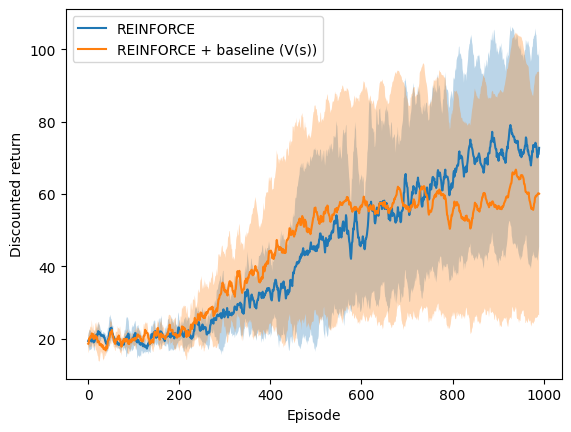

In [ ]:
import os
import random
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym
import mlflow

from plotting import plot_compare_smoothed_rewards


# -------------------------
# Config
# -------------------------
@dataclass
class PGConfig:
    env_id: str = "CartPole-v1"

    gamma: float = 0.99

    hidden_dim: int = 128
    init_low: float = -0.001
    init_high: float = 0.001

    episodes: int = 1000
    max_steps_per_episode: int = 1000  # safety cap

    # Boltzmann temperature schedule
    T0: float = 10.0
    T_decay: float = 0.99
    T_min: float = 0.5

    # Learning rates per assignment
    alpha_pi: float = 1e-4
    alpha_v: float = 1e-3

    device: str = "cuda" if torch.cuda.is_available() else "cpu"


# -------------------------
# Utils
# -------------------------
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def discounted_return(rewards: List[float], gamma: float) -> float:
    """G0 = sum_t gamma^t r_t"""
    G = 0.0
    p = 1.0
    for r in rewards:
        G += p * r
        p *= gamma
    return float(G)


def compute_mc_returns(rewards: List[float], gamma: float) -> np.ndarray:
    """Return array of MC returns G_t for each timestep t."""
    G = 0.0
    out = np.zeros(len(rewards), dtype=np.float32)
    for t in reversed(range(len(rewards))):
        G = rewards[t] + gamma * G
        out[t] = G
    return out


def obs_to_tensor(obs: np.ndarray, device: str) -> torch.Tensor:
    return torch.from_numpy(obs.astype(np.float32)).to(device)


# -------------------------
# Networks
# -------------------------
def init_small_uniform(m: nn.Module, low: float, high: float):
    if isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight, a=low, b=high)
        if m.bias is not None:
            nn.init.uniform_(m.bias, a=low, b=high)


class PolicyMLP(nn.Module):
    """Outputs logits z(s,a)."""

    def __init__(self, obs_dim: int, n_actions: int, hidden_dim: int, init_low: float, init_high: float):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_actions),
        )
        self.apply(lambda m: init_small_uniform(m, init_low, init_high))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)  # logits


class ValueMLP(nn.Module):
    """Approximates V(s)."""

    def __init__(self, obs_dim: int, hidden_dim: int, init_low: float, init_high: float):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )
        self.apply(lambda m: init_small_uniform(m, init_low, init_high))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x).squeeze(-1)  # scalar


# -------------------------
# Boltzmann policy helpers
# -------------------------
def softmax_with_temperature(logits: torch.Tensor, T: float) -> torch.Tensor:
    """
    logits: (A,) or (B,A)
    returns: probs same shape
    """
    scaled = logits / T
    scaled = scaled - scaled.max(dim=-1, keepdim=True).values
    return torch.softmax(scaled, dim=-1)


@torch.no_grad()
def sample_action(policy: PolicyMLP, obs: np.ndarray, T: float, device: str) -> int:
    s = obs_to_tensor(obs, device)
    logits = policy(s)                  # (A,)
    probs = softmax_with_temperature(logits, T)
    a = torch.multinomial(probs, num_samples=1).item()
    return int(a)


def log_prob_action(policy: PolicyMLP, s: torch.Tensor, a: torch.Tensor, T: float) -> torch.Tensor:
    logits = policy(s)                  # (A,)
    probs = softmax_with_temperature(logits, T)
    return torch.log(probs[a] + 1e-12)


# -------------------------
# One run (one seed) - REINFORCE
# -------------------------
def run_reinforce(seed: int, cfg: PGConfig) -> List[float]:
    set_seed(seed)

    env = gym.make(cfg.env_id)
    obs_dim = int(env.observation_space.shape[0])
    n_actions = int(env.action_space.n)

    policy = PolicyMLP(obs_dim, n_actions, cfg.hidden_dim, cfg.init_low, cfg.init_high).to(cfg.device)
    opt_pi = optim.Adam(policy.parameters(), lr=cfg.alpha_pi)

    episode_returns: List[float] = []
    T = cfg.T0

    for ep in range(cfg.episodes):
        obs, info = env.reset(seed=seed + ep)

        states: List[np.ndarray] = []
        actions: List[int] = []
        rewards: List[float] = []

        terminated = False
        truncated = False
        steps = 0

        while not (terminated or truncated) and steps < cfg.max_steps_per_episode:
            a = sample_action(policy, obs, T, cfg.device)
            next_obs, r, terminated, truncated, info = env.step(a)

            states.append(obs)
            actions.append(a)
            rewards.append(float(r))

            obs = next_obs
            steps += 1

        # discounted return per episode (for plotting)
        G0 = discounted_return(rewards, cfg.gamma)
        episode_returns.append(G0)

        # MC returns for per-step updates
        Gs = compute_mc_returns(rewards, cfg.gamma)

        # 1 gradient step per environment step
        for s_np, a_int, G in zip(states, actions, Gs):
            s_t = obs_to_tensor(s_np, cfg.device)
            a_t = torch.tensor(a_int, dtype=torch.long, device=cfg.device)
            G_t = torch.tensor(G, dtype=torch.float32, device=cfg.device)

            logp = log_prob_action(policy, s_t, a_t, T)
            loss_pi = -(logp * G_t)

            opt_pi.zero_grad()
            loss_pi.backward()
            opt_pi.step()

        # Temperature schedule per episode
        T = max(cfg.T_min, cfg.T_decay * T)

        # MLflow logging
        if (ep + 1) % 100 == 0:
            print(f"[seed={seed}] "
            f"Episode {ep+1}/{cfg.episodes} | "
            f"Steps this ep: {steps} | "
            f"Temp this ep: {T} | ")
            mlflow.log_metric("discounted_return", float(G0), step=ep)
            mlflow.log_metric("temperature", float(T), step=ep)

    env.close()
    return episode_returns


# -------------------------
# One run (one seed) - REINFORCE + baseline
# -------------------------
def run_reinforce_with_baseline(seed: int, cfg: PGConfig) -> List[float]:
    set_seed(seed)

    env = gym.make(cfg.env_id)
    obs_dim = int(env.observation_space.shape[0])
    n_actions = int(env.action_space.n)

    policy = PolicyMLP(obs_dim, n_actions, cfg.hidden_dim, cfg.init_low, cfg.init_high).to(cfg.device)
    value = ValueMLP(obs_dim, cfg.hidden_dim, cfg.init_low, cfg.init_high).to(cfg.device)

    opt_pi = optim.Adam(policy.parameters(), lr=cfg.alpha_pi)
    opt_v = optim.Adam(value.parameters(), lr=cfg.alpha_v)

    episode_returns: List[float] = []
    T = cfg.T0

    for ep in range(cfg.episodes):
        obs, info = env.reset(seed=seed + ep)

        states: List[np.ndarray] = []
        actions: List[int] = []
        rewards: List[float] = []

        terminated = False
        truncated = False
        steps = 0

        while not (terminated or truncated) and steps < cfg.max_steps_per_episode:
            a = sample_action(policy, obs, T, cfg.device)
            next_obs, r, terminated, truncated, info = env.step(a)

            states.append(obs)
            actions.append(a)
            rewards.append(float(r))

            obs = next_obs
            steps += 1

        # discounted return per episode
        G0 = discounted_return(rewards, cfg.gamma)
        episode_returns.append(G0)

        # MC returns G_t
        Gs = compute_mc_returns(rewards, cfg.gamma)

        # 1 gradient step per environment step (value + policy each step)
        for s_np, a_int, G in zip(states, actions, Gs):
            s_t = obs_to_tensor(s_np, cfg.device)
            a_t = torch.tensor(a_int, dtype=torch.long, device=cfg.device)
            G_t = torch.tensor(G, dtype=torch.float32, device=cfg.device)

            # --- baseline update: fit V(s) to G_t ---
            V_s = value(s_t)
            loss_v = F.mse_loss(V_s, G_t)

            opt_v.zero_grad()
            loss_v.backward()
            opt_v.step()

            # --- policy update with advantage A_t = G_t - V(s_t) ---
            # detach baseline to prevent policy gradients through value net
            with torch.no_grad():
                V_det = value(s_t)
            adv = G_t - V_det

            logp = log_prob_action(policy, s_t, a_t, T)
            loss_pi = -(logp * adv)

            opt_pi.zero_grad()
            loss_pi.backward()
            opt_pi.step()

        T = max(cfg.T_min, cfg.T_decay * T)

        if (ep + 1) % 100 == 0:
            print(f"[seed={seed}] "
            f"Episode {ep+1}/{cfg.episodes} | "
            f"Steps this ep: {steps} | "
            f"Temp this ep: {T} | ")
            mlflow.log_metric("discounted_return", float(G0), step=ep)
            mlflow.log_metric("temperature", float(T), step=ep)

    env.close()
    return episode_returns


# -------------------------
# Experiment: 5 seeds, 2 methods, compare plot
# -------------------------
def experiment_q4a(
    cfg: PGConfig,
    seeds=(0, 1, 2, 3, 4),
    mlflow_experiment_name="COMP579_A3_Q4a_REINFORCE"
) -> Dict[str, List[List[float]]]:
    """
    Returns dict:
      {
        "reinforce": [seed_returns, ...],
        "reinforce_baseline": [seed_returns, ...]
      }
    """
    mlflow.set_experiment(mlflow_experiment_name)

    results: Dict[str, List[List[float]]] = {
        "reinforce": [],
        "reinforce_baseline": [],
    }

    # Parent run for the whole Q4(a) experiment
    with mlflow.start_run(run_name="Q4a_REINFORCE_vs_Baseline", nested=False):
        mlflow.log_params({
            "env": cfg.env_id,
            "gamma": cfg.gamma,
            "episodes": cfg.episodes,
            "max_steps_per_episode": cfg.max_steps_per_episode,
            "hidden_dim": cfg.hidden_dim,
            "init_low": cfg.init_low,
            "init_high": cfg.init_high,
            "optimizer": "Adam",
            "alpha_pi": cfg.alpha_pi,
            "alpha_v": cfg.alpha_v,
            "T0": cfg.T0,
            "T_decay": cfg.T_decay,
            "T_min": cfg.T_min,
            "device": cfg.device,
        })

        # ---- Method 1: REINFORCE ----
        with mlflow.start_run(run_name="method=reinforce", nested=True):
            for seed in seeds:
                with mlflow.start_run(run_name=f"seed={seed}", nested=True):
                    mlflow.log_param("seed", seed)
                    returns = run_reinforce(seed=seed, cfg=cfg)
                    results["reinforce"].append(returns)
                    mlflow.log_metric("final_100ep_mean_return", float(np.mean(returns[-100:])))

        # ---- Method 2: REINFORCE + baseline ----
        with mlflow.start_run(run_name="method=reinforce_baseline", nested=True):
            for seed in seeds:
                with mlflow.start_run(run_name=f"seed={seed}", nested=True):
                    mlflow.log_param("seed", seed)
                    returns = run_reinforce_with_baseline(seed=seed, cfg=cfg)
                    results["reinforce_baseline"].append(returns)
                    mlflow.log_metric("final_100ep_mean_return", float(np.mean(returns[-100:])))

    # Plot comparison: 2 curves (mean±std across seeds)
    train_rewards_list = [results["reinforce"], results["reinforce_baseline"]]
    labels = ["REINFORCE", "REINFORCE + baseline (V(s))"]

    plot_compare_smoothed_rewards(
        train_rewards_list=train_rewards_list,
        labels=labels,
        window=10,
        xlabel="Episode",
        ylabel="Discounted return",
    )

    return results


# -------------------------
# Main
# -------------------------
if __name__ == "__main__":
    cfg = PGConfig(
        env_id="CartPole-v1",
        gamma=0.99,
        episodes=1000,
        max_steps_per_episode=1000,   # cap
        hidden_dim=128,
        init_low=-0.001,
        init_high=0.001,
        T0=10.0,
        T_decay=0.99,
        T_min=0.5,
        alpha_pi=1e-4,
        alpha_v=1e-3,
    )

    experiment_q4a(cfg)

## 4) (A) Results Analysis

From this plot of "Discounted Return" vs "Episode" we can draw several conclusions. Firstly, we can clearly see a learning behaviour in both algorithms. The difference relies on two main aspects: speed of learning and consistency (variance across episodes).

In the beginning, REINFORCE WITH BASELINE has lower variance than REINFORCE. This translates into faster learning and greater discounted return in the early episodes (approximately 0 to 500). The reason is that the baseline reduces the variance of the gradient estimate without changing its expectation. By subtracting a baseline v(s), the algorithm reduces the noise in the policy update. This variance reduction improves stability and sample efficiency, especially in the early training phase when returns are highly noisy.

However, from around episode 500 onward, REINFORCE overtakes REINFORCE WITH BASELINE, and the variance appears to be lower as well. This can happen if the learned baseline is not accurate enough or introduces additional estimation noise. Since the baseline itself must be learned (through Monte Carlo returns), errors in its estimation may bias the practical updates or slow improvement. In contrast, vanilla REINFORCE directly uses returns, which, although high variance, are unbiased with respect to the true policy gradient.

Near the final episodes we see that REINFORCE achieves a higher discounted return, being above 60, while the alternative with baseline remains slightly below. This suggests that, in this specific setting, the simpler estimator eventually reaches a better-performing policy. However, this behaviour could change in later episodes, as policy gradient methods are sensitive to step-size choices and stochastic effects. With more training, a well-learned baseline typically stabilizes learning and can outperform the no-baseline version in expectation, even if short-term fluctuations favor the simpler approach.

Overall, both methods exhibit correct learning dynamics, but their relative performance depends strongly on variance reduction quality, baseline accuracy, and optimization hyperparameters.

## 4) (b) Code

2026/02/23 14:05:00 INFO mlflow.tracking.fluent: Experiment with name 'COMP579_A3_Q4b_Temperature_Sweep' does not exist. Creating a new experiment.


[seed=0] Episode 100/1000 | Steps this ep: 34 | Temp this ep: 0.1 | 
[seed=0] Episode 200/1000 | Steps this ep: 65 | Temp this ep: 0.1 | 
[seed=0] Episode 300/1000 | Steps this ep: 55 | Temp this ep: 0.1 | 
[seed=0] Episode 400/1000 | Steps this ep: 87 | Temp this ep: 0.1 | 
[seed=0] Episode 500/1000 | Steps this ep: 486 | Temp this ep: 0.1 | 
[seed=0] Episode 600/1000 | Steps this ep: 500 | Temp this ep: 0.1 | 
[seed=0] Episode 700/1000 | Steps this ep: 71 | Temp this ep: 0.1 | 
[seed=0] Episode 800/1000 | Steps this ep: 500 | Temp this ep: 0.1 | 
[seed=0] Episode 900/1000 | Steps this ep: 474 | Temp this ep: 0.1 | 
[seed=0] Episode 1000/1000 | Steps this ep: 182 | Temp this ep: 0.1 | 
[seed=1] Episode 100/1000 | Steps this ep: 18 | Temp this ep: 0.1 | 
[seed=1] Episode 200/1000 | Steps this ep: 13 | Temp this ep: 0.1 | 
[seed=1] Episode 300/1000 | Steps this ep: 23 | Temp this ep: 0.1 | 
[seed=1] Episode 400/1000 | Steps this ep: 12 | Temp this ep: 0.1 | 
[seed=1] Episode 500/1000 | 

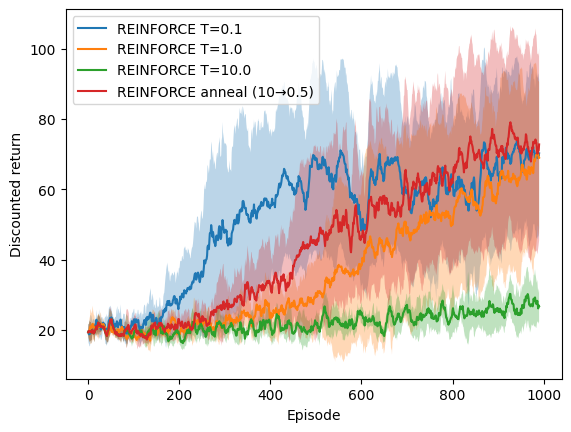

In [ ]:
import random
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import mlflow

from plotting import plot_compare_smoothed_rewards


# -------------------------
# Config (reuse from Q4a + add mode)
# -------------------------
@dataclass
class PGConfig:
    env_id: str = "CartPole-v1"
    gamma: float = 0.99

    hidden_dim: int = 128
    init_low: float = -0.001
    init_high: float = 0.001

    episodes: int = 1000
    max_steps_per_episode: int = 1000

    # Annealing schedule params (used only if temperature_mode="anneal")
    T0: float = 10.0
    T_decay: float = 0.99
    T_min: float = 0.5

    alpha_pi: float = 1e-4

    device: str = "cuda" if torch.cuda.is_available() else "cpu"


# -------------------------
# Utils
# -------------------------
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def discounted_return(rewards: List[float], gamma: float) -> float:
    G = 0.0
    p = 1.0
    for r in rewards:
        G += p * r
        p *= gamma
    return float(G)


def compute_mc_returns(rewards: List[float], gamma: float) -> np.ndarray:
    G = 0.0
    out = np.zeros(len(rewards), dtype=np.float32)
    for t in reversed(range(len(rewards))):
        G = rewards[t] + gamma * G
        out[t] = G
    return out


def obs_to_tensor(obs: np.ndarray, device: str) -> torch.Tensor:
    return torch.from_numpy(obs.astype(np.float32)).to(device)


# -------------------------
# Networks 
# -------------------------
def init_small_uniform(m: nn.Module, low: float, high: float):
    if isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight, a=low, b=high)
        if m.bias is not None:
            nn.init.uniform_(m.bias, a=low, b=high)


class PolicyMLP(nn.Module):
    def __init__(self, obs_dim: int, n_actions: int, hidden_dim: int, init_low: float, init_high: float):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_actions),
        )
        self.apply(lambda m: init_small_uniform(m, init_low, init_high))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


# -------------------------
# Boltzmann helpers (same)
# -------------------------
def softmax_with_temperature(logits: torch.Tensor, T: float) -> torch.Tensor:
    scaled = logits / T
    scaled = scaled - scaled.max(dim=-1, keepdim=True).values
    return torch.softmax(scaled, dim=-1)


@torch.no_grad()
def sample_action(policy: PolicyMLP, obs: np.ndarray, T: float, device: str) -> int:
    s = obs_to_tensor(obs, device)
    logits = policy(s)
    probs = softmax_with_temperature(logits, T)
    return int(torch.multinomial(probs, 1).item())


def log_prob_action(policy: PolicyMLP, s: torch.Tensor, a: torch.Tensor, T: float) -> torch.Tensor:
    logits = policy(s)
    probs = softmax_with_temperature(logits, T)
    return torch.log(probs[a] + 1e-12)


# -------------------------
# Temperature schedule utility
# -------------------------
def temperature_for_episode(
    ep_idx: int,
    mode: str,
    cfg: PGConfig,
    fixed_T: Optional[float] = None,
) -> float:
    """
    mode:
      - "fixed": return fixed_T
      - "anneal": return max(T_min, T0 * (T_decay ** ep_idx))
    """
    if mode == "fixed":
        if fixed_T is None:
            raise ValueError("fixed_T must be provided when mode='fixed'")
        return float(fixed_T)

    if mode == "anneal":
        return float(max(cfg.T_min, cfg.T0 * (cfg.T_decay ** ep_idx)))

    raise ValueError(f"Unknown temperature mode: {mode}")


# -------------------------
# One run (one seed) — Base REINFORCE, parameterized by temperature variant
# -------------------------
def run_reinforce_temperature_variant(
    seed: int,
    cfg: PGConfig,
    temperature_mode: str,          # "fixed" or "anneal"
    fixed_T: Optional[float] = None # only used if mode="fixed"
) -> List[float]:
    set_seed(seed)

    env = gym.make(cfg.env_id)
    obs_dim = int(env.observation_space.shape[0])
    n_actions = int(env.action_space.n)

    policy = PolicyMLP(obs_dim, n_actions, cfg.hidden_dim, cfg.init_low, cfg.init_high).to(cfg.device)
    opt_pi = optim.Adam(policy.parameters(), lr=cfg.alpha_pi)

    episode_returns: List[float] = []

    for ep in range(cfg.episodes):
        T = temperature_for_episode(ep, temperature_mode, cfg, fixed_T)

        obs, info = env.reset(seed=seed + ep)
        states: List[np.ndarray] = []
        actions: List[int] = []
        rewards: List[float] = []

        terminated = False
        truncated = False
        steps = 0

        while not (terminated or truncated) and steps < cfg.max_steps_per_episode:
            a = sample_action(policy, obs, T, cfg.device)
            next_obs, r, terminated, truncated, info = env.step(a)

            states.append(obs)
            actions.append(a)
            rewards.append(float(r))

            obs = next_obs
            steps += 1

        G0 = discounted_return(rewards, cfg.gamma)
        episode_returns.append(G0)

        Gs = compute_mc_returns(rewards, cfg.gamma)

        # 1 gradient step per environment step
        for s_np, a_int, G in zip(states, actions, Gs):
            s_t = obs_to_tensor(s_np, cfg.device)
            a_t = torch.tensor(a_int, dtype=torch.long, device=cfg.device)
            G_t = torch.tensor(G, dtype=torch.float32, device=cfg.device)

            logp = log_prob_action(policy, s_t, a_t, T)
            loss_pi = -(logp * G_t)

            opt_pi.zero_grad()
            loss_pi.backward()
            opt_pi.step()

        if (ep + 1) % 100 == 0:
            print(f"[seed={seed}] "
            f"Episode {ep+1}/{cfg.episodes} | "
            f"Steps this ep: {steps} | "
            f"Temp this ep: {T} | ")
            mlflow.log_metric("discounted_return", float(G0), step=ep)
            mlflow.log_metric("temperature", float(T), step=ep)

    env.close()
    return episode_returns


# -------------------------
# Experiment Q4(b): 4 variants × 5 seeds + plot
# -------------------------
def experiment_q4b(
    cfg: PGConfig,
    seeds=(0, 1, 2, 3, 4),
    mlflow_experiment_name="COMP579_A3_Q4b_Temperature_Sweep",
):
    """
    Variants:
      - fixed T=0.1
      - fixed T=1.0
      - fixed T=10.0
      - anneal (T0=10, decay=0.99, floor=0.5)
    """
    mlflow.set_experiment(mlflow_experiment_name)

    variants: List[Tuple[str, str, Optional[float]]] = [
        ("fixed_T=0.1", "fixed", 0.1),
        ("fixed_T=1.0", "fixed", 1.0),
        ("fixed_T=10.0", "fixed", 10.0),
        ("anneal_T0=10_decay=0.99_floor=0.5", "anneal", None),
    ]

    results: Dict[str, List[List[float]]] = {name: [] for name, _, _ in variants}

    # Parent run for this question
    with mlflow.start_run(run_name="Q4b_Temperature_Comparison", nested=False):
        mlflow.log_params({
            "env": cfg.env_id,
            "gamma": cfg.gamma,
            "episodes": cfg.episodes,
            "max_steps_per_episode": cfg.max_steps_per_episode,
            "hidden_dim": cfg.hidden_dim,
            "init_low": cfg.init_low,
            "init_high": cfg.init_high,
            "optimizer": "Adam",
            "alpha_pi": cfg.alpha_pi,
            "T0": cfg.T0,
            "T_decay": cfg.T_decay,
            "T_min": cfg.T_min,
            "device": cfg.device,
        })

        for variant_name, mode, fixed_T in variants:
            # nested run per variant
            with mlflow.start_run(run_name=f"variant={variant_name}", nested=True):
                mlflow.log_param("temperature_mode", mode)
                if fixed_T is not None:
                    mlflow.log_param("fixed_T", fixed_T)

                per_seed: List[List[float]] = []
                for seed in seeds:
                    with mlflow.start_run(run_name=f"seed={seed}", nested=True):
                        mlflow.log_param("seed", seed)
                        returns = run_reinforce_temperature_variant(
                            seed=seed,
                            cfg=cfg,
                            temperature_mode=mode,
                            fixed_T=fixed_T,
                        )
                        per_seed.append(returns)
                        mlflow.log_metric("final_100ep_mean_return", float(np.mean(returns[-100:])))

                results[variant_name] = per_seed

    # Plot: 4 curves (each curve mean±std across seeds)
    train_rewards_list = [results[name] for name, _, _ in variants]
    labels = [
        "REINFORCE T=0.1",
        "REINFORCE T=1.0",
        "REINFORCE T=10.0",
        "REINFORCE anneal (10→0.5)",
    ]

    plot_compare_smoothed_rewards(
        train_rewards_list=train_rewards_list,
        labels=labels,
        window=10,
        xlabel="Episode",
        ylabel="Discounted return",
    )

    return results


if __name__ == "__main__":
    cfg = PGConfig(
        env_id="CartPole-v1",
        gamma=0.99,
        episodes=1000,
        max_steps_per_episode=1000,
        hidden_dim=128,
        init_low=-0.001,
        init_high=0.001,
        T0=10.0,
        T_decay=0.99,
        T_min=0.5,
        alpha_pi=1e-4,
    )

    experiment_q4b(cfg)

## 4) (b) Results Analysis

In this plot of "Discounted Return" vs "Episode" where we vary the temperature, we observe clear differences in exploration behaviour.

For T = 10, the results are the worst. Learning is almost imperceptible compared to the other temperatures. After 1000 episodes, the discounted return remains close to its initial value, only slightly above 20. The only positive aspect is that the variance is extremely low. This is expected, since a high temperature makes the softmax policy nearly uniform, leading to excessive exploration and very weak preference updates. The agent does not exploit good actions effectively.

For T = 1, we see a slow but consistent learning behaviour with moderate variance. Around episode 1000 it approaches the other configurations, surpassing 60 in discounted return. This temperature provides a reasonable balance between exploration and exploitation.

For T = 0.1, as expected, we observe the fastest learning behaviour but also the least consistent one. Variance is high, and after episode 500 we do not see a clear improvement trend. This happens because a very low temperature makes the policy nearly greedy. Early on, this accelerates improvement, but it also increases sensitivity to noisy return estimates, which can lead to instability and premature convergence to suboptimal actions.

Finally, the configuration that appears best overall is the annealing schedule (from 10 to 0.5 gradually). This approach provides faster learning than T = 1 and lower variance than T = 0.1. By episode 1000 it reaches slightly above 60, similar to T = 1 and T = 0.1. The advantage of annealing is that it encourages exploration early, when uncertainty is high, and gradually shifts toward exploitation as learning progresses. This dynamic balance often leads to more robust performance across training.

## 4) (c) Code

2026/02/23 14:49:05 INFO mlflow.tracking.fluent: Experiment with name 'COMP579_A3_Q4c_OneStep_ActorCritic' does not exist. Creating a new experiment.


[seed=0] Episode 100/1000 | Steps this ep: 20.0 | Temp this ep: 3.697296376497264 | 
[seed=0] Episode 200/1000 | Steps this ep: 12.0 | Temp this ep: 1.3533300490703204 | 
[seed=0] Episode 300/1000 | Steps this ep: 25.0 | Temp this ep: 0.5 | 
[seed=0] Episode 400/1000 | Steps this ep: 18.0 | Temp this ep: 0.5 | 
[seed=0] Episode 500/1000 | Steps this ep: 12.0 | Temp this ep: 0.5 | 
[seed=0] Episode 600/1000 | Steps this ep: 26.0 | Temp this ep: 0.5 | 
[seed=0] Episode 700/1000 | Steps this ep: 11.0 | Temp this ep: 0.5 | 
[seed=0] Episode 800/1000 | Steps this ep: 13.0 | Temp this ep: 0.5 | 
[seed=0] Episode 900/1000 | Steps this ep: 14.0 | Temp this ep: 0.5 | 
[seed=0] Episode 1000/1000 | Steps this ep: 12.0 | Temp this ep: 0.5 | 
[seed=1] Episode 100/1000 | Steps this ep: 17.0 | Temp this ep: 3.697296376497264 | 
[seed=1] Episode 200/1000 | Steps this ep: 34.0 | Temp this ep: 1.3533300490703204 | 
[seed=1] Episode 300/1000 | Steps this ep: 94.0 | Temp this ep: 0.5 | 
[seed=1] Episode 4

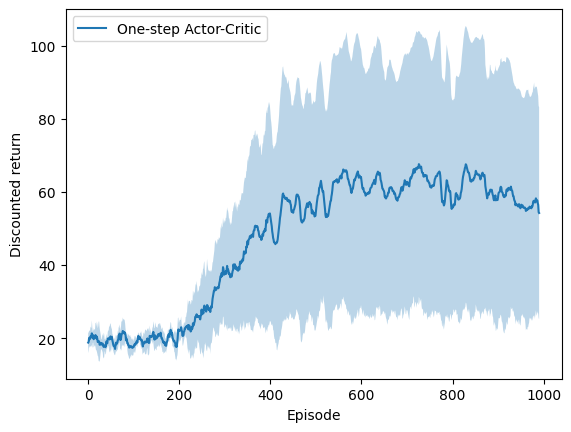

In [ ]:
import random
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym
import mlflow

from plotting import plot_compare_smoothed_rewards


# -------------------------
# Config
# -------------------------
@dataclass
class PGConfig:
    env_id: str = "CartPole-v1"
    gamma: float = 0.99

    hidden_dim: int = 128
    init_low: float = -0.001
    init_high: float = 0.001

    episodes: int = 1000
    max_steps_per_episode: int = 1000

    # Boltzmann annealing schedule
    T0: float = 10.0
    T_decay: float = 0.99
    T_min: float = 0.5

    # Learning rates per spec
    alpha_pi: float = 1e-4   # actor
    alpha_v: float = 1e-3    # critic

    device: str = "cuda" if torch.cuda.is_available() else "cpu"


# -------------------------
# Utils
# -------------------------
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def obs_to_tensor(obs: np.ndarray, device: str) -> torch.Tensor:
    return torch.from_numpy(obs.astype(np.float32)).to(device)


def discounted_return(rewards: List[float], gamma: float) -> float:
    G = 0.0
    p = 1.0
    for r in rewards:
        G += p * r
        p *= gamma
    return float(G)


def temperature_for_episode(ep_idx: int, cfg: PGConfig) -> float:
    return float(max(cfg.T_min, cfg.T0 * (cfg.T_decay ** ep_idx)))


# -------------------------
# Networks
# -------------------------
def init_small_uniform(m: nn.Module, low: float, high: float):
    if isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight, a=low, b=high)
        if m.bias is not None:
            nn.init.uniform_(m.bias, a=low, b=high)


class PolicyMLP(nn.Module):
    """Actor: outputs logits z(s,a)."""

    def __init__(self, obs_dim: int, n_actions: int, hidden_dim: int, init_low: float, init_high: float):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_actions),
        )
        self.apply(lambda m: init_small_uniform(m, init_low, init_high))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class ValueMLP(nn.Module):
    """Critic: approximates V(s)."""

    def __init__(self, obs_dim: int, hidden_dim: int, init_low: float, init_high: float):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )
        self.apply(lambda m: init_small_uniform(m, init_low, init_high))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x).squeeze(-1)


# -------------------------
# Boltzmann helpers
# -------------------------
def softmax_with_temperature(logits: torch.Tensor, T: float) -> torch.Tensor:
    scaled = logits / T
    scaled = scaled - scaled.max(dim=-1, keepdim=True).values
    return torch.softmax(scaled, dim=-1)


@torch.no_grad()
def sample_action(policy: PolicyMLP, obs: np.ndarray, T: float, device: str) -> int:
    s = obs_to_tensor(obs, device)
    logits = policy(s)
    probs = softmax_with_temperature(logits, T)
    return int(torch.multinomial(probs, 1).item())


def log_prob_action(policy: PolicyMLP, s: torch.Tensor, a: torch.Tensor, T: float) -> torch.Tensor:
    logits = policy(s)
    probs = softmax_with_temperature(logits, T)
    return torch.log(probs[a] + 1e-12)


# -------------------------
# One run (one seed) — One-step Actor-Critic
# -------------------------
def run_one_step_actor_critic(seed: int, cfg: PGConfig) -> List[float]:
    """
    Online, per-step updates:
      td_target = r + gamma * V(s') * (1-done)
      delta     = td_target - V(s)
      critic loss: (V(s) - td_target)^2
      actor loss : -logπ(a|s) * delta
    """
    set_seed(seed)

    env = gym.make(cfg.env_id)
    obs_dim = int(env.observation_space.shape[0])
    n_actions = int(env.action_space.n)

    actor = PolicyMLP(obs_dim, n_actions, cfg.hidden_dim, cfg.init_low, cfg.init_high).to(cfg.device)
    critic = ValueMLP(obs_dim, cfg.hidden_dim, cfg.init_low, cfg.init_high).to(cfg.device)

    opt_pi = optim.Adam(actor.parameters(), lr=cfg.alpha_pi)
    opt_v = optim.Adam(critic.parameters(), lr=cfg.alpha_v)

    episode_returns: List[float] = []

    for ep in range(cfg.episodes):
        T = temperature_for_episode(ep, cfg)

        obs, info = env.reset(seed=seed + ep)
        terminated = False
        truncated = False
        steps = 0

        ep_rewards: List[float] = []

        while not (terminated or truncated) and steps < cfg.max_steps_per_episode:
            # current state
            s_t = obs_to_tensor(obs, cfg.device)

            # act
            a_int = sample_action(actor, obs, T, cfg.device)
            a_t = torch.tensor(a_int, dtype=torch.long, device=cfg.device)

            # env step
            next_obs, r, terminated, truncated, info = env.step(a_int)
            ep_rewards.append(float(r))

            # next state tensor
            s_tp1 = obs_to_tensor(next_obs, cfg.device)

            # compute values
            V_s = critic(s_t)          # scalar
            with torch.no_grad():
                V_sp1 = critic(s_tp1)  # scalar

            done = float(terminated or truncated)
            td_target = torch.tensor(float(r), device=cfg.device) + cfg.gamma * V_sp1 * (1.0 - done)
            delta = td_target - V_s

            # ---- critic update ----
            # minimize (V(s) - td_target)^2
            loss_v = F.mse_loss(V_s, td_target)

            opt_v.zero_grad()
            loss_v.backward()
            opt_v.step()

            # ---- actor update ----
            # use delta detached so actor doesn't backprop through critic
            logp = log_prob_action(actor, s_t, a_t, T)
            loss_pi = -(logp * delta.detach())

            opt_pi.zero_grad()
            loss_pi.backward()
            opt_pi.step()

            obs = next_obs
            steps += 1

        G0 = discounted_return(ep_rewards, cfg.gamma)
        episode_returns.append(G0)

        if (ep + 1) % 100 == 0:
            print(f"[seed={seed}] "
            f"Episode {ep+1}/{cfg.episodes} | "
            f"Steps this ep: {float(len(ep_rewards))} | "
            f"Temp this ep: {T} | ")
            mlflow.log_metric("discounted_return", float(G0), step=ep)
            mlflow.log_metric("temperature", float(T), step=ep)
            mlflow.log_metric("episode_len", float(len(ep_rewards)), step=ep)

    env.close()
    return episode_returns


# -------------------------
# Experiment Q4(c): 5 seeds + plot
# -------------------------
def experiment_q4c(
    cfg: PGConfig,
    seeds=(0, 1, 2, 3, 4),
    mlflow_experiment_name="COMP579_A3_Q4c_OneStep_ActorCritic",
) -> Dict[str, List[List[float]]]:
    """
    Returns:
      {"actor_critic": [seed_returns, ...]}
    """
    mlflow.set_experiment(mlflow_experiment_name)
    results: Dict[str, List[List[float]]] = {"actor_critic": []}

    with mlflow.start_run(run_name="Q4c_OneStep_ActorCritic", nested=False):
        mlflow.log_params({
            "env": cfg.env_id,
            "gamma": cfg.gamma,
            "episodes": cfg.episodes,
            "max_steps_per_episode": cfg.max_steps_per_episode,
            "hidden_dim": cfg.hidden_dim,
            "init_low": cfg.init_low,
            "init_high": cfg.init_high,
            "optimizer": "Adam",
            "alpha_pi": cfg.alpha_pi,
            "alpha_v": cfg.alpha_v,
            "T0": cfg.T0,
            "T_decay": cfg.T_decay,
            "T_min": cfg.T_min,
            "device": cfg.device,
            "algorithm": "one_step_actor_critic",
        })

        for seed in seeds:
            with mlflow.start_run(run_name=f"seed={seed}", nested=True):
                mlflow.log_param("seed", seed)
                returns = run_one_step_actor_critic(seed=seed, cfg=cfg)
                results["actor_critic"].append(returns)
                mlflow.log_metric("final_100ep_mean_return", float(np.mean(returns[-100:])))

    plot_compare_smoothed_rewards(
        train_rewards_list=[results["actor_critic"]],
        labels=["One-step Actor-Critic"],
        window=10,
        xlabel="Episode",
        ylabel="Discounted return",
    )

    return results


if __name__ == "__main__":
    cfg = PGConfig(
        env_id="CartPole-v1",
        gamma=0.99,
        episodes=1000,
        max_steps_per_episode=1000,
        hidden_dim=128,
        init_low=-0.001,
        init_high=0.001,
        T0=10.0,
        T_decay=0.99,
        T_min=0.5,
        alpha_pi=1e-4,
        alpha_v=1e-3,
    )

    experiment_q4c(cfg)

## 4) (c) Results Analysis

For the one-step actor-critic "Discounted Return" vs "Episode" plot we can observe a learning behaviour that starts with low variance and relatively stable improvement. Before episode 500 it demonstrates good learning behaviour.

However, after that point returns stop increasing significantly. The algorithm seems to have gotten stuck. This behaviour can be explained by the bias introduced by bootstrapping. Unlike REINFORCE, actor-critic methods use a critic to estimate the value function. While this reduces variance compared to Monte Carlo returns, it introduces bias due to imperfect value estimates. If the critic is not accurate enough, the policy updates may become misaligned, preventing further improvement.

In addition, instability can arise from the interaction between actor and critic updates. If learning rates are not well tuned, the critic may not track the true value function accurately, which can limit policy improvement and cause premature convergence.

## 4) (d) Code

2026/02/23 15:18:44 INFO mlflow.tracking.fluent: Experiment with name 'COMP579_A3_Q4d_AC_CriticLR_Sweep' does not exist. Creating a new experiment.


[seed=0] Episode 100/1000 | Steps this ep: 20.0 | Temp this ep: 3.697296376497264 | 
[seed=0] Episode 200/1000 | Steps this ep: 11.0 | Temp this ep: 1.3533300490703204 | 
[seed=0] Episode 300/1000 | Steps this ep: 29.0 | Temp this ep: 0.5 | 
[seed=0] Episode 400/1000 | Steps this ep: 32.0 | Temp this ep: 0.5 | 
[seed=0] Episode 500/1000 | Steps this ep: 22.0 | Temp this ep: 0.5 | 
[seed=0] Episode 600/1000 | Steps this ep: 15.0 | Temp this ep: 0.5 | 
[seed=0] Episode 700/1000 | Steps this ep: 16.0 | Temp this ep: 0.5 | 
[seed=0] Episode 800/1000 | Steps this ep: 47.0 | Temp this ep: 0.5 | 
[seed=0] Episode 900/1000 | Steps this ep: 25.0 | Temp this ep: 0.5 | 
[seed=0] Episode 1000/1000 | Steps this ep: 16.0 | Temp this ep: 0.5 | 
[seed=1] Episode 100/1000 | Steps this ep: 19.0 | Temp this ep: 3.697296376497264 | 
[seed=1] Episode 200/1000 | Steps this ep: 14.0 | Temp this ep: 1.3533300490703204 | 
[seed=1] Episode 300/1000 | Steps this ep: 19.0 | Temp this ep: 0.5 | 
[seed=1] Episode 4

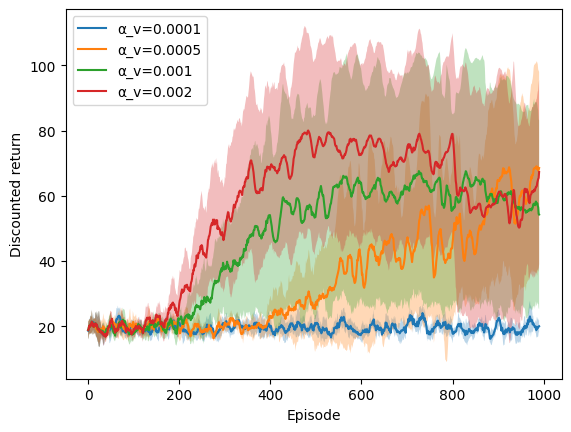

In [ ]:
import random
from dataclasses import dataclass, replace
from typing import List, Dict, Optional, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym
import mlflow

from plotting import plot_compare_smoothed_rewards


# -------------------------
# Config
# -------------------------
@dataclass
class PGConfig:
    env_id: str = "CartPole-v1"
    gamma: float = 0.99

    hidden_dim: int = 128
    init_low: float = -0.001
    init_high: float = 0.001

    episodes: int = 1000
    max_steps_per_episode: int = 1000

    # Boltzmann annealing
    T0: float = 10.0
    T_decay: float = 0.99
    T_min: float = 0.5

    alpha_pi: float = 1e-4   # actor 
    alpha_v: float = 1e-3    # critic 

    device: str = "cuda" if torch.cuda.is_available() else "cpu"


# -------------------------
# Utils
# -------------------------
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def obs_to_tensor(obs: np.ndarray, device: str) -> torch.Tensor:
    return torch.from_numpy(obs.astype(np.float32)).to(device)


def discounted_return(rewards: List[float], gamma: float) -> float:
    G = 0.0
    p = 1.0
    for r in rewards:
        G += p * r
        p *= gamma
    return float(G)


def temperature_for_episode(ep_idx: int, cfg: PGConfig) -> float:
    return float(max(cfg.T_min, cfg.T0 * (cfg.T_decay ** ep_idx)))


# -------------------------
# Networks 
# -------------------------
def init_small_uniform(m: nn.Module, low: float, high: float):
    if isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight, a=low, b=high)
        if m.bias is not None:
            nn.init.uniform_(m.bias, a=low, b=high)


class PolicyMLP(nn.Module):
    def __init__(self, obs_dim: int, n_actions: int, hidden_dim: int, init_low: float, init_high: float):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_actions),
        )
        self.apply(lambda m: init_small_uniform(m, init_low, init_high))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class ValueMLP(nn.Module):
    def __init__(self, obs_dim: int, hidden_dim: int, init_low: float, init_high: float):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )
        self.apply(lambda m: init_small_uniform(m, init_low, init_high))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x).squeeze(-1)


# -------------------------
# Boltzmann helpers
# -------------------------
def softmax_with_temperature(logits: torch.Tensor, T: float) -> torch.Tensor:
    scaled = logits / T
    scaled = scaled - scaled.max(dim=-1, keepdim=True).values
    return torch.softmax(scaled, dim=-1)


@torch.no_grad()
def sample_action(policy: PolicyMLP, obs: np.ndarray, T: float, device: str) -> int:
    s = obs_to_tensor(obs, device)
    logits = policy(s)
    probs = softmax_with_temperature(logits, T)
    return int(torch.multinomial(probs, 1).item())


def log_prob_action(policy: PolicyMLP, s: torch.Tensor, a: torch.Tensor, T: float) -> torch.Tensor:
    logits = policy(s)
    probs = softmax_with_temperature(logits, T)
    return torch.log(probs[a] + 1e-12)


# -------------------------
# One run (one seed) — One-step Actor-Critic
# -------------------------
def run_one_step_actor_critic(seed: int, cfg: PGConfig) -> List[float]:
    set_seed(seed)

    env = gym.make(cfg.env_id)
    obs_dim = int(env.observation_space.shape[0])
    n_actions = int(env.action_space.n)

    actor = PolicyMLP(obs_dim, n_actions, cfg.hidden_dim, cfg.init_low, cfg.init_high).to(cfg.device)
    critic = ValueMLP(obs_dim, cfg.hidden_dim, cfg.init_low, cfg.init_high).to(cfg.device)

    opt_pi = optim.Adam(actor.parameters(), lr=cfg.alpha_pi)
    opt_v = optim.Adam(critic.parameters(), lr=cfg.alpha_v)

    episode_returns: List[float] = []

    for ep in range(cfg.episodes):
        T = temperature_for_episode(ep, cfg)

        obs, info = env.reset(seed=seed + ep)
        terminated = False
        truncated = False
        steps = 0
        ep_rewards: List[float] = []

        while not (terminated or truncated) and steps < cfg.max_steps_per_episode:
            s_t = obs_to_tensor(obs, cfg.device)

            a_int = sample_action(actor, obs, T, cfg.device)
            a_t = torch.tensor(a_int, dtype=torch.long, device=cfg.device)

            next_obs, r, terminated, truncated, info = env.step(a_int)
            ep_rewards.append(float(r))
            s_tp1 = obs_to_tensor(next_obs, cfg.device)

            V_s = critic(s_t)
            with torch.no_grad():
                V_sp1 = critic(s_tp1)

            done = float(terminated or truncated)
            td_target = torch.tensor(float(r), device=cfg.device) + cfg.gamma * V_sp1 * (1.0 - done)
            delta = td_target - V_s

            # critic
            loss_v = F.mse_loss(V_s, td_target)
            opt_v.zero_grad()
            loss_v.backward()
            opt_v.step()

            # actor
            logp = log_prob_action(actor, s_t, a_t, T)
            loss_pi = -(logp * delta.detach())
            opt_pi.zero_grad()
            loss_pi.backward()
            opt_pi.step()

            obs = next_obs
            steps += 1

        G0 = discounted_return(ep_rewards, cfg.gamma)
        episode_returns.append(G0)

        if (ep + 1) % 100 == 0:
            print(f"[seed={seed}] "
            f"Episode {ep+1}/{cfg.episodes} | "
            f"Steps this ep: {float(len(ep_rewards))} | "
            f"Temp this ep: {T} | ")
            mlflow.log_metric("discounted_return", float(G0), step=ep)
            mlflow.log_metric("temperature", float(T), step=ep)
            mlflow.log_metric("episode_len", float(len(ep_rewards)), step=ep)

    env.close()
    return episode_returns


# -------------------------
# Experiment Q4(d): sweep alpha_v, 5 seeds each, plot 4 curves
# -------------------------
def experiment_q4d(
    cfg: PGConfig,
    alpha_vs=(1e-4, 5e-4, 1e-3, 2e-3),
    seeds=(0, 1, 2, 3, 4),
    mlflow_experiment_name="COMP579_A3_Q4d_AC_CriticLR_Sweep",
) -> Dict[float, List[List[float]]]:
    """
    Returns dict:
      { alpha_v : [seed_returns, ...], ... }
    """
    mlflow.set_experiment(mlflow_experiment_name)

    results: Dict[float, List[List[float]]] = {}

    with mlflow.start_run(run_name="Q4d_CriticLR_Sweep", nested=False):
        mlflow.log_params({
            "env": cfg.env_id,
            "gamma": cfg.gamma,
            "episodes": cfg.episodes,
            "max_steps_per_episode": cfg.max_steps_per_episode,
            "hidden_dim": cfg.hidden_dim,
            "init_low": cfg.init_low,
            "init_high": cfg.init_high,
            "optimizer": "Adam",
            "alpha_pi": cfg.alpha_pi,
            "T0": cfg.T0,
            "T_decay": cfg.T_decay,
            "T_min": cfg.T_min,
            "device": cfg.device,
            "algorithm": "one_step_actor_critic",
            "sweep_param": "alpha_v",
            "alpha_v_values": str(list(alpha_vs)),
        })

        for av in alpha_vs:
            per_seed_returns: List[List[float]] = []

            # Run group for this critic LR
            with mlflow.start_run(run_name=f"alpha_v={av:g}", nested=True):
                mlflow.log_param("alpha_v", av)

                # override cfg.alpha_v but keep everything else identical
                cfg_av = replace(cfg, alpha_v=float(av))

                for seed in seeds:
                    with mlflow.start_run(run_name=f"seed={seed}", nested=True):
                        mlflow.log_param("seed", seed)

                        returns = run_one_step_actor_critic(seed=seed, cfg=cfg_av)
                        per_seed_returns.append(returns)

                        mlflow.log_metric("final_100ep_mean_return", float(np.mean(returns[-100:])))

            results[float(av)] = per_seed_returns

    # Plot: 4 curves (mean±std across seeds)
    train_rewards_list = [results[float(av)] for av in alpha_vs]
    labels = [f"α_v={av:g}" for av in alpha_vs]

    plot_compare_smoothed_rewards(
        train_rewards_list=train_rewards_list,
        labels=labels,
        window=10,
        xlabel="Episode",
        ylabel="Discounted return",
    )

    return results


if __name__ == "__main__":
    cfg = PGConfig(
        env_id="CartPole-v1",
        gamma=0.99,
        episodes=1000,
        max_steps_per_episode=1000,
        hidden_dim=128,
        init_low=-0.001,
        init_high=0.001,
        T0=10.0,
        T_decay=0.99,
        T_min=0.5,
        alpha_pi=1e-4,
        alpha_v=1e-3,  # included in sweep anyway
    )

    experiment_q4d(cfg)

## 4) (d) Results Analysis

In this "Discounted Return" vs "Episode" plot where we compare learning rates, we observe the following:

LR = 0.0001 is the worst performing configuration. The learning rate is so small that almost no learning behaviour is observable within 1000 episodes. However, variance is the lowest because updates are extremely small and stable. This indicates underfitting and very slow policy improvement.

LR = 0.0005 shows slow but consistent learning. Variance grows gradually, and by episode 1000 it achieves the highest returns, even though it was the second worst configuration around episode 500. This suggests that this learning rate provides a good balance between stability and speed of convergence. It is large enough to allow meaningful updates, but small enough to prevent instability.

For LR = 0.001 and 0.002, the learning rate appears to be too high. In the beginning learning is fast, and returns increase quickly. However, after reaching a peak around episode 500, the returns decrease and the learning curve becomes unstable. This is likely due to overly large gradient steps, which cause oscillations or divergence in the policy parameters. In policy gradient methods, large learning rates can amplify variance and lead to unstable updates, especially when using stochastic gradient estimates.

Overall, these results are consistent with theoretical expectations: too small learning rates slow down convergence, while too large learning rates cause instability. An intermediate value provides the best long-term performance.